## Masked Face Recognition
> 作为 `**遮挡状态下的活体人脸身份识别项目**`的其中一个环节，遮挡状态下的人脸特征提取模型，主要通过CBAM模块结合预训练ResNet50，让模型集中在不被口罩遮挡部分的人脸特征，提高识别率。借鉴VGGFace的训练方式，先利用ArcFace softmax loss对模型进行分类训练，后续再通过Triplet和attention loss对模型进行fine tuning。

项目过程中的主要困难点、亮点和相关方案：
- 数据处理：需要根据现有数据集，创建戴口罩的数据用于训练和验证
- 模型结构：设计组合骨干模型、CBAM block的不同搭配
- 消融实验：对比了在不同模型结构、训练数据的搭配、embbedding dim，以及不同loss的训练方式等设置下的AUC、ACC等
- 模型加速：GPU提速，以及相关tricks的调参
- 模型checkpoints训练日志：通过同步保存optimizer和scheduler状态，根据日志信息，基于上一个保存的最优模型继续训练，最大限度抑制再训练可能导致的反弹情况，逐步迭代最大化AUC
- 项目文件的导入路径问题：使用sys.path更新项目环境路径
- 项目整合：整合项目所有文件和参数配置，方便在终端通过命令或执行脚本指定参数，从而开启自定义训练
- 模型部署：整合预训练模型，并通过class实例化调用

In [1]:
# Analysis
import os
import numpy as np
import pandas as pd
import math
import random
import glob

# Plotting
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['Arial Unicode MS'] 
plt.rcParams['axes.unicode_minus']=False 

# Framework
import torch
import torch.nn as nn
import torch.nn.functional as F

> ### Data

#### VGGFace2 Dataset
`preprocess/load_data.py`

Check dataset [here](https://www.robots.ox.ac.uk/~vgg/data/vgg_face/) and [download](https://aistudio.baidu.com/aistudio/datasetdetail/13135)

原训练集包括9131个人的照片共20GB，由于太大，本项目把原测试集的500个人共2GB约17万张照片当作训练集使用。

In [2]:
DATA_ROOT = 'datasets' 
TRAIN_PATH = 'vggface2_train' #检测对齐前的原始图片
TRAIN_LIST = 'vggface2_train.csv' 

In [3]:
# 根据VGGFace2数据创建data list，包括图片路径，以及对应人name和label
def create_train_list(path):
    data = []
    ppl_list = os.listdir(path) # 得到以人名命名的folder列表
    ppl_list.sort()
    for name_id, name in enumerate(ppl_list):
        name_path = os.path.join(path, name) #由于mac可能有.DS_Store等隐藏文件
        if os.path.isdir(name_path): #跳过文件
            image_list = os.listdir(name_path)
            image_list.sort()
            for image in image_list: #每个人的图片路径
                data.append([os.path.join(path, name, image), name, name_id])

    data = pd.DataFrame(data, columns = ['path','name','label'])
    data.to_csv(f'{path}.csv', index=False)
    return data

In [188]:
train = create_train_list(os.path.join(DATA_ROOT, TRAIN_PATH))
train.head()

,path,name,label
0,datasets/vggface2_train_n/n000001/0001_01.jpg,n000001,0
1,datasets/vggface2_train_n/n000001/0002_01.jpg,n000001,0
2,datasets/vggface2_train_n/n000001/0003_01.jpg,n000001,0
3,datasets/vggface2_train_n/n000001/0004_01.jpg,n000001,0
4,datasets/vggface2_train_n/n000001/0005_01.jpg,n000001,0


In [4]:
def load_train_list(path):  
    data = pd.read_csv(path, sep=',')
    print(f'We have loaded {data.shape[0]:,} samples belonging to {len(np.unique(data["name"]))} people.\n')
    return data

In [5]:
train = load_train_list(os.path.join(DATA_ROOT,TRAIN_LIST))
train.head()

We have loaded 169,396 samples belonging to 500 people.



,path,name,label
0,datasets/vggface2_train/n000001/0001_01.jpg,n000001,0
1,datasets/vggface2_train/n000001/0002_01.jpg,n000001,0
2,datasets/vggface2_train/n000001/0003_01.jpg,n000001,0
3,datasets/vggface2_train/n000001/0004_01.jpg,n000001,0
4,datasets/vggface2_train/n000001/0005_01.jpg,n000001,0


In [192]:
# 每个人的照片数量不一样，imbalanced class
train['name'].value_counts()

n004563    761
n001242    644
n003217    641
n001878    638
n008361    617
          ... 
n005668    123
n004068    120
n009175    113
n001850     99
n006987     98
Name: name, Length: 500, dtype: int64

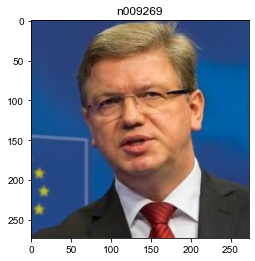

In [377]:
idx = np.random.choice(len(train))
plt.imshow(plt.imread(train['path'][idx]))
plt.title(train['name'][idx]);

#### LFW Dataset
Check dataset [here](http://vis-www.cs.umass.edu/lfw/#download) and download:
- [lfw-funneled.tgz](http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz): All images aligned with funneling
- [pairs.txt](http://vis-www.cs.umass.edu/lfw/pairs.txt): training paradigms ([README](http://vis-www.cs.umass.edu/lfw/README.txt))

测试集包括5749个人共1万3张照片，共6000组pairs。

In [ ]:
#下载数据集后解码
!tar -xzvf Datasets/lfw-funneled.tgz 

In [5]:
VAL_PATH = 'lfw_funneled' #检测对齐前的原始图片
VAL_LIST = 'pairs.txt'

In [7]:
# 加载LFW列表，包含两种pairs：同一个人的2张图片id，或者不同人各自的图片id
def load_test_list(path):  
    data = pd.read_csv(path, delimiter='\t', skiprows=1, names=['name1','id1-1','id1-2/name2','id2'])
    same_pairs = data[data['id2'].isnull()].reset_index(drop=True) #
    diff_pairs = data[data['id2'].notnull()].reset_index(drop=True) #
    diff_pairs['id2']=diff_pairs['id2'].astype('int') #由于和nan同列，变为float，需要转回int
    print(f'We have loaded {same_pairs.shape[0]} pairs belonging to the same person, and {diff_pairs.shape[0]} pairs that are not.')
    return same_pairs, diff_pairs

In [127]:
same, diff = load_test_list(os.path.join(DATA_ROOT,VAL_LIST))
same.head()
diff.head()

We have loaded 3000 pairs belonging to the same person, and 3000 pairs that are not.


,name1,id1-1,id1-2/name2,id2
0,Abel_Pacheco,1,4,NaN
1,Akhmed_Zakayev,1,3,NaN
2,Akhmed_Zakayev,2,3,NaN
3,Amber_Tamblyn,1,2,NaN
4,Anders_Fogh_Rasmussen,1,3,NaN


,name1,id1-1,id1-2/name2,id2
0,Abdel_Madi_Shabneh,1,Dean_Barker,1
1,Abdel_Madi_Shabneh,1,Giancarlo_Fisichella,1
2,Abdel_Madi_Shabneh,1,Mikhail_Gorbachev,1
3,Abdul_Rahman,1,Portia_de_Rossi,1
4,Abel_Pacheco,1,Jong_Thae_Hwa,2


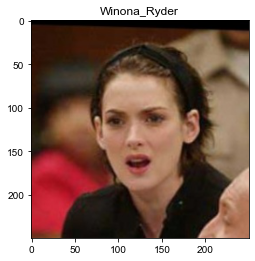

In [179]:
idx = np.random.choice(len(same))
name = same['name1'][idx]
file = f'{name}_{int(same["id1-1"][idx]):04}.jpg'
plt.imshow(plt.imread(os.path.join(DATA_ROOT, VAL_PATH, name, file)))
plt.title(same['name1'][idx]);

#### Masked Dataset
`preprocess/create_masked_dataset.py`

基于原始VGGFace2/LFW人脸库，做人脸检测和对齐处理，根据需要额外创建不同的数据集:
- 正脸对齐截图
- 戴口罩版的正脸对齐截图
- 未覆盖人脸部位的mask图和Bbox坐标.txt

或者直接下载 [Real-World Masked Face Dataset](https://github.com/X-zhangyang/Real-World-Masked-Face-Dataset)

In [8]:
from tqdm import tqdm
import dlib #在AI Studio安装pip install dlib-bin，否则会内存溢出
import copy

In [9]:
IMAGE_SIZE = 256 #截图统一尺寸

In [10]:
TRAIN_FACE_PATH = 'vggface2_train_face' #原版正脸对齐截图
TRAIN_MASKED_FACE_PATH = 'vggface2_train_masked_face' #戴口罩版的正脸对齐截图
TRAIN_MASK_PATH = 'vggface2_train_mask' #未覆盖人脸部位的mask
TRAIN_MASK_BBOX_PATH = 'vggface2_train_mask_bbox' #未覆盖人脸部位的(x,y)坐标范围.txt

In [11]:
VAL_FACE_PATH = 'lfw_funneled' #原版正脸对齐截图
VAL_MASKED_FACE_PATH = 'lfw_funneled_masked' #戴口罩版的正脸对齐截图

Download [shape predictor 68 face landmarks](http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2)

In [12]:
# 初始化模型
detector = dlib.get_frontal_face_detector() # 人脸检测模型
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat') #68个关键点检测模型        

In [159]:
# 创建戴口罩数据集
def create_masked_dataset(path, start_p=0.0, end_p=1.0, random_p=None, unmasked=False, masked=False, mask=False,
                          face_path=TRAIN_FACE_PATH, masked_face_path=TRAIN_MASKED_FACE_PATH, 
                          mask_path=TRAIN_MASK_PATH, mask_bbox_path=TRAIN_MASK_BBOX_PATH):
    # 创建数据集方式
    data = []
    ppl_list = os.listdir(path) # 得到以人名命名的folder列表
    ppl_list.sort()
    n_ppl = len(ppl_list) #原数据集总人数
    
    # Method 1: 如果需要全部转换，由于速度会太慢，可以通过shell后台运行脚本，同步处理多组数据
    if (start_p is not None) and (end_p is not None):
        ppl_list = ppl_list[int(start_p*n_ppl):int(end_p*n_ppl)]
        
    # Method 2: 如果只需要抽取其中一部分做成小数据集：
    elif random_p is not None:
        ppl_list = np.random.choice(ppl_list, int(random_p*n_ppl), replace=False)
    ppl_list.sort() #随机抽取组成新数据集的人
    skip_num = 0 #记录有多少图片因为检测不到/超过1个以上人脸，而被跳过
    
    # 基于原数据集，遍历每个人的每张照片，进行改造
    print(f'Creating new datasets for {len(ppl_list)} people from {ppl_list[0]} to {ppl_list[-1]}...')
    for name in tqdm(ppl_list):
        image_list = os.listdir(os.path.join(path, name))
        image_list.sort()
        if unmasked: #要创建不戴口罩版本
            if not os.path.exists(os.path.join(DATA_ROOT, face_path, name)):
                os.makedirs(os.path.join(DATA_ROOT, face_path, name))
        if masked: #要创建戴口罩版本
            if not os.path.exists(os.path.join(DATA_ROOT, masked_face_path, name)):
                os.makedirs(os.path.join(DATA_ROOT, masked_face_path, name))
        if mask: #要创建戴口罩对应的mask (validation不需要)
            if not os.path.exists(os.path.join(DATA_ROOT, mask_path, name)):
                os.makedirs(os.path.join(DATA_ROOT, mask_path, name))
            if not os.path.exists(os.path.join(DATA_ROOT, mask_bbox_path, name)):
                os.makedirs(os.path.join(DATA_ROOT, mask_bbox_path, name))
        
        for image in image_list: #每个人的图片路径
            image_path = os.path.join(path, name, image)
            image_face_path = os.path.join(DATA_ROOT, face_path, name, image)
            image_masked_face_path = os.path.join(DATA_ROOT, masked_face_path, name, image)
            image_mask_path = os.path.join(DATA_ROOT, mask_path, name, image)
            image_mask_bbox_path = os.path.join(DATA_ROOT, mask_bbox_path, name, os.path.splitext(image)[0]+'.txt')
            skip_num = create_masked_face(image_path, image_face_path, image_masked_face_path, image_mask_path, image_mask_bbox_path,
                               unmasked, masked, mask, skip_num)
    print(f'Datasets generated with {skip_num} images skipped!')

In [160]:
# 创建戴口罩图片
def create_masked_face(image_path, image_face_path, image_masked_face_path, image_mask_path, image_mask_bbox_path,
                       unmasked=False, masked=False, mask=False, skip_num=0):
    image = cv2.imread(image_path) #BGR
    face_align, mask_align = None, None #设置初始值
    
    # 人脸检测，返回bbox坐标
    bboxes = detector(image, upsample_num_times=1) #返回bbox坐标[[(x1,y1) (x2,y2)],[...]]
    if len(bboxes) == 1:  #若只检测到1个人脸，由于检测到多张脸时，情况会很复杂，未免混乱都跳过      
        # 对原图检测到的人脸提取人脸关键点
        landmarks = predictor(image, bboxes[0]) #若有多组landmarks的话，用dlib.full_objection_detections().append(landmarks)
        face_align = dlib.get_face_chip(image, face=landmarks, #关键点对齐人脸，旋转恢复水平正面
                                        size=IMAGE_SIZE) #resize得到放大居中的人脸框截图
        face_align_unmasked = copy.deepcopy(face_align) #备份一个不被口罩遮挡的对齐截图

        if masked: #如果创建戴口罩数据
            bboxes = detector(face_align, upsample_num_times=1) #对水平的正脸截图重新提取人脸关键点
            if len(bboxes) == 1:  
                # 关键点位置：脸型：0-16，左眉：17-21，右眉：22-26，鼻梁：27-30，鼻子：31-35
                #           左眼：顺时针36-41，右眼：顺时针42-47，嘴巴：48-68
                landmarks = predictor(face_align, bboxes[0]) 

                # 下半脸：创建多边形随机颜色口罩
                bottom = []
                for i in range(2, 15, 1): # 耳下脸部关键点
                    bottom.append([landmarks.part(i).x, landmarks.part(i).y])
                bottom = np.array(bottom)
                colors = [(200, 183, 144), (163, 150, 134), (172, 170, 169), \
                          (167, 168, 166), (173, 171, 170), (161, 161, 160), \
                          (170, 162, 162)] #不同颜色的口罩
                color = colors[np.random.randint(0,len(colors),[])]
                cv2.fillConvexPoly(face_align, bottom, color) 
                
                if mask: #如果需要返回对应的mask和bbox
                    eyebrow_list = [18,20,23,25] #对齐眼角的眉毛位置
                    eyes_list = [36,39,42,45] #眼睛的左右眼角
                    eyebrow = 0
                    eyes = 0
                    # 求眼角和眉毛之间的平均距离，即眼睑的高度
                    for eb, ey in zip(eyebrow_list, eyes_list):
                        eyebrow += landmarks.part(eb).y
                        eyes += landmarks.part(ey).y
                    extras = int(eyes/4 - eyebrow/4) 

                    # 上半脸：创建mask，用白色凸包convex hull标识没有被遮盖的上半脸
                    upper = []
                    for i in [0,1,2,14,15,16,17,18,19,20,23,24,25,26]: #耳侧脸部和眉毛关键点
                        if i in eyebrow_list: #眉毛关键点往上移动两个眼睑的距离，即把额头的位置也放到提取人脸特征的区域范围
                            y = (landmarks.part(i).y-2*extras) if (landmarks.part(i).y-2*extras) > 0 else 0 #超过图片上方取0
                        else:
                            y = landmarks.part(i).y
                        upper.append([landmarks.part(i).x, y])
                    upper = np.array(upper)
                    hull = cv2.convexHull(upper) #找到能涵盖所有关键点的最小凸包
                    mask_align = np.zeros(face_align.shape, dtype=np.uint8) #全黑mask底图
                    mask_align = cv2.fillPoly(mask_align, [hull], [255, 255, 255]) #用白色填充凸包

                    # 获取上半脸的Bbox坐标
                    h, w, c = face_align.shape
                    xmin, ymin = np.clip(np.min(upper, axis=0), 0, None) #不小于0
                    xmax = np.clip(np.max(upper, axis=0)[0], None, w) #不超过图片范围
                    ymax = np.clip(np.max(upper, axis=0)[1], None, h)
            else:
                face_align=None #避免首次检测到人脸，结果再次检测失败的情况，为了所有状态都能一一对应，若第二次失败则不创建该组数据

    # 只有成功创建新图时，才保存图片，后续创建dataset时直接从新路径读取，所以不会存在检测不到人脸的图片
    if face_align is not None: 
        if unmasked: #要创建不带口罩版本
            cv2.imwrite(image_face_path, face_align_unmasked) #原图
        if masked: #要创建戴口罩版本
            cv2.imwrite(image_masked_face_path, face_align) #保存口罩图片
        if mask: 
            cv2.imwrite(image_mask_path, mask_align) #mask
            with open(image_mask_bbox_path, 'w') as f: #记录不被遮挡脸部的Bbox坐标
                f.write(f'{xmin},{ymin},{xmax},{ymax}\n')
    else:
        skip_num += 1 
    return skip_num

In [161]:
# 基于VGGFace2 for training
create_masked_dataset(os.path.join(DATA_ROOT, TRAIN_PATH), unmasked=True, masked=True, mask=True)

Creating new datasets for 3 people from n000001 to n000029...


100%|█████████████████████████████████████████████| 3/3 [02:55<00:00, 58.50s/it]

Datasets generated with 196 images skipped!


In [27]:
# 基于LFW for validation
create_masked_dataset(os.path.join(DATA_ROOT, VAL_PATH), unmasked=False, masked=True, mask=False,
                     face_path=VAL_FACE_PATH, masked_face_path=VAL_MASKED_FACE_PATH)

Creating new datasets for 3 people...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  7.44it/s]

Datasets generated with 0 images skipped!


`preprocess/create_masked_dataset.sh`: 用脚本分区创建戴口罩数据，速度更快

`python create_masked_dataset.py --start_p=0.0 --end_p=0.1 --unmasked=True  --masked=True  --mask=True`

In [ ]:
# 在终端运行模型时，用命令行参数解析设置config
import argparse
parser = argparse.ArgumentParser(description='Generate masked datasets in sections')
parser.add_argument('--start_p', type=float, default=0.0)
parser.add_argument('--end_p', type=float, default=0.1)
parser.add_argument('--unmasked', type=bool, default=False)
parser.add_argument('--masked', type=bool, default=False)
parser.add_argument('--mask', type=bool, default=False)
config = parser.parse_args()
print(config)
create_masked_dataset(os.path.join(DATA_ROOT, TRAIN_PATH), start_p=config.start_p, end_p=config.end_p,
                      unmasked=config.unmasked, masked=config.masked, mask=config.mask)

In [50]:
# 为新创建的数据集生成data list
versions = [TRAIN_FACE_PATH, TRAIN_MASKED_FACE_PATH]
for path in versions:
    train = create_train_list(os.path.join(DATA_ROOT, path))
    train.head()

,path,name,label
0,datasets/vggface2_train_face/n000001/0001_01.jpg,n000001,1
1,datasets/vggface2_train_face/n000001/0002_01.jpg,n000001,1
2,datasets/vggface2_train_face/n000001/0003_01.jpg,n000001,1
3,datasets/vggface2_train_face/n000001/0004_01.jpg,n000001,1
4,datasets/vggface2_train_face/n000001/0005_01.jpg,n000001,1


,path,name,label
0,datasets/vggface2_train_masked_face/n000001/00...,n000001,1
1,datasets/vggface2_train_masked_face/n000001/00...,n000001,1
2,datasets/vggface2_train_masked_face/n000001/00...,n000001,1
3,datasets/vggface2_train_masked_face/n000001/00...,n000001,1
4,datasets/vggface2_train_masked_face/n000001/00...,n000001,1


In [32]:
# 随机显示各个版本下的图片，由于原图中有很多无法被制作成masked图，所以以TRAIN_FACE_PATH版本为标准
def show_versions(versions, titles):
    train = load_train_list(os.path.join(DATA_ROOT,TRAIN_FACE_PATH+'.csv')) 
    idx = np.random.choice(len(train))
    plt.figure(figsize=(12,3))
    for i, ver in enumerate(versions):
        path = train['path'][idx].replace(TRAIN_FACE_PATH, ver) #以
        plt.subplot(1,4,i+1)
        plt.imshow(plt.imread(path))
        plt.title(titles[i])
        plt.axis(False)
    plt.suptitle(train['name'][idx],fontsize=13)
    plt.show()

We have loaded 30 samples belonging to 3 people.



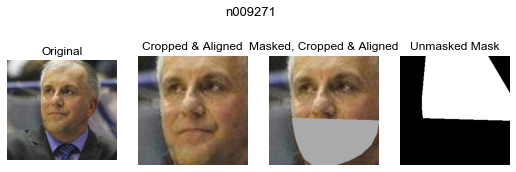

In [33]:
# 查看已生成的数据集
versions = [TRAIN_PATH, TRAIN_FACE_PATH, TRAIN_MASKED_FACE_PATH, TRAIN_MASK_PATH]
titles = ['Original', 'Cropped & Aligned', 'Masked, Cropped & Aligned', 'Unmasked Mask']
show_versions(versions, titles)

<a id='dataset'></a>
首先，我们需要明确Training/Validation/Test set的分布，确保我们的训练方向与实际应用相符。

实际应用场景中，员工的照片通常为不戴口罩版本，而实际需要识别的情景包括戴和不戴口罩两种，Training和Test set的分布不一致，导致错误率变大。为避免模型根据不戴口罩照片(全脸特征)得到的emb可能难以识别戴口罩后的同一个人(只剩下上半脸特征)，我们需要训练一个模型使其能仅通过上半部分脸就作出判断。

参考VGGFace训练方式，我们先通过**ArcFace版的Softmax**进行多分类训练，让模型学会通过上半脸特征，最大化不同人之间的差距，关于训练集的组成有以下想法：
- 只用不戴口罩照片
- 只用戴口罩照片：更偏向这种，迫使模型集中于上半脸
- 混合戴口罩和不戴口罩照片

然后再通过**Triplet loss**最小化同一人的差异，最大化不同人的差异，可尝试配合**Attention loss**辅助模型在训练期间把注意力集中到上半脸。关于Triplets的组合，为了增加AP和AN难度，有以下想法：
- masked (A + P + N)：正常搭配，进一步拉开masked AN差距，用masked LFW进行验证
- masked A + unmasked P + unmasked N：虽然模型可能已经把重点关注在上半脸，但是当下半脸露出时，和原本大片色块的口罩差距变大，也可能会导致混乱使难度变大，使AP、AN差距都变大，用unmasked LFW进行验证
- masked A + unmasked P + masked N：当AN都戴口罩时差距变小，相反AP差距变大，为了使AP差距比AN更小，再进一步促进模型学习
- 同理A用unmasked，然后其他搭配相反

#### Create Single Dataset 
<a id='single'></a>
`preprocess/single_dataset.py`

In [14]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import multiprocessing

In [227]:
# 针对单张图片的数据集：image, label
class SingleDataset(Dataset):
    def __init__(self, img_size=256, transform=None, masked=True, mode='train', train_size=0.8):
        if masked: #基于不同数据集
            data_list = TRAIN_MASKED_FACE_PATH+'.csv' 
        else:
            data_list = TRAIN_FACE_PATH+'.csv' 
        self.transform = transform
        self.data = load_train_list(os.path.join(DATA_ROOT, data_list))
        if mode=='train':
            self.data, _ = train_test_split(self.data, train_size=train_size, random_state=0, 
                                            shuffle=True, stratify=self.data['label'])
        elif mode=='test':
            _, self.data = train_test_split(self.data, train_size=train_size, random_state=0, 
                                            shuffle=True, stratify=self.data['label'])
        
    def __len__(self):
        return len(self.data)             
    
    def __getitem__(self, idx):
        img_path, name, label = self.data.iloc[idx]
        img = cv2.imread(img_path)
        if self.transform:
            img = self.transform(img) #float32 [c,h,w]
        label = torch.LongTensor([int(label)]) #int64
        return img, label

In [108]:
BATCH_SIZE = 30

In [109]:
train_transform = transforms.Compose([
    transforms.ToTensor(), #把array/PIL从[0,255]转为[0,1]的FloatTensor [c,h,w]
    transforms.RandomHorizontalFlip(), # 随机翻转 PIL/tensor
    # transforms.Normalize( #对tensor的channel进行normalization
    #     mean=[0.5, 0.5, 0.5],
    #     std=[0.5, 0.5, 0.5])
])

In [112]:
train_dataset = SingleDataset(img_size=256, transform = train_transform, masked=True, mode='train')
train_loader  = DataLoader(train_dataset, shuffle=True, batch_size = BATCH_SIZE, 
                           drop_last=True, num_workers=0) 

We have loaded 30 samples belonging to 3 people.



In [135]:
def show_single(sample): #显示图片/mask
    image = np.transpose(sample[0].numpy(), (1,2,0)) #(h,w,c)
    plt.imshow(image[...,::-1]) #rgb
    plt.title(f'Label: {sample[1].numpy()[0]}')
    plt.axis(False)
    plt.show();

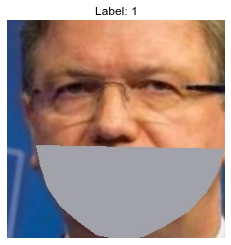

In [203]:
idx = np.random.choice(train_dataset.__len__())
sample = train_dataset[idx]
show_single(sample)

#### Create Triplet Dataset
<a id='triplet'></a>
`preprocess/triplet_dataset.py`

参考[上述思考](#dataset)，创建triplets三元组：
- masked (A + P + N): 60%
- masked A + unmasked P + unmasked N: 20%
- masked A + unmasked P + masked N: 20%

同理：
- unmasked (A + P + N): 60%
- unmasked A + masked P + masked N: 20%
- unmasked A + masked P + unmasked N: 20%

In [223]:
# 针对三元组的数据集：Anchor, Positive, Negative, Label1, Label2
class TripletDataset(Dataset):
    def __init__(self, img_size=256, transform=None, masked=True, fusion=False, mask=False, bbox=False, n_triplets=1000): 
        if masked: #基于不同数据集
            self.data_list = TRAIN_MASKED_FACE_PATH+'.csv' 
        else:
            self.data_list = TRAIN_FACE_PATH+'.csv' 
        if fusion: #以masked为主的基础上，稍微混合不一样版本的
            self.pos_fusion, self.neg_fusion = 0.4, 0.5
        else:
            self.pos_fusion, self.neg_fusion = 0.0, 0.0 

        self.img_size = img_size
        self.transform = transform
        self.masked = masked
        self.mask = mask
        self.bbox = bbox
        
        # 如果有配好的triplets数据就直接用，要不就生成一下
        triplets_path = os.path.join(DATA_ROOT, 
                        f"{self.data_list[9:-4]}_triplets_{'fusion_' if fusion else ''}{n_triplets}.npy") #省去vggface2_(xxx).csv
        if os.path.exists(triplets_path):
            print("Loading triplets dataset...")
            self.triplets = np.load(triplets_path)
            print(f"Triplets dataset with {n_triplets} samples loaded.")
        else:
            print('Generating triplets dataset...')
            self.triplets = self.generate_triplets(triplets_path, n_triplets)

            
    def generate_triplets(self, triplets_path, n_triplets):
        data = load_train_list(os.path.join(DATA_ROOT, self.data_list))
        labels = np.unique(data["label"])
        n_ppl = len(labels) #人数
        images = {i:data[data['label']==i]['path'].to_list() for i in labels} #得到每个人的图片路径列表
        triplets = [] 
        type1, type2, type3 = 0, 0, 0 #三种类型样本的数量
        
        # 由于组合太多，只随机创建1000组samples
        for _ in tqdm(range(n_triplets)): 
            # 随机选两个类当做正类负类
            pos_class, neg_class = np.random.choice(labels, 2, replace=False)
            
            # 如果选出来的正类里的图片数少于2就重新选一个正类
            while len(images[pos_class]) < 2:
                pos_class, neg_class = np.random.choice(labels, 2, replace=False)
    
            # 创建数据集
            pos_name = data[data['label']==pos_class]['name'].iloc[0]
            neg_name = data[data['label']==neg_class]['name'].iloc[0]
            anc_idx, pos_idx = np.random.choice(len(images[pos_class]), 2, replace=False)
            neg_idx = np.random.choice(len(images[neg_class]))
            
            anc_path = images[pos_class][anc_idx]
            pos_path = images[pos_class][pos_idx]
            neg_path = images[neg_class][neg_idx]
            if np.random.rand() < self.pos_fusion: #40%概率下P换成不一样版本的，或者不换
                pos_path = pos_path.replace(os.path.splitext(self.data_list)[0], TRAIN_FACE_PATH if self.masked else TRAIN_MASKED_FACE_PATH) 
                if np.random.rand() < self.neg_fusion: #50%概率下N换成不一样版本的，或者不换
                    neg_path = neg_path.replace(os.path.splitext(self.data_list)[0], TRAIN_FACE_PATH if self.masked else TRAIN_MASKED_FACE_PATH) 
                    type3+=1 #统计不同类型的样本数量
                else:
                    type2+=1
            else:
                type1+=1
                
            triplets.append([anc_path, pos_path, neg_path, 
                             pos_class, neg_class, 
                             pos_name, neg_name])

        np.save(triplets_path, triplets)
        print(f"Triplets dataset with {n_triplets} samples generated ({type1} Type1 + {type2} Type2 + {type3} Type3) and saved to: {triplets_path}")
        return triplets
    
    def __len__(self):
        return len(self.triplets)             
          
    def get_mask(self, image_path): #由于image_path已经有可能发生变化，随机masked/unmasked
        if TRAIN_MASKED_FACE_PATH in image_path:
            mask_path = image_path.replace(TRAIN_MASKED_FACE_PATH, TRAIN_MASK_PATH)
        else:
            mask_path = image_path.replace(TRAIN_FACE_PATH, TRAIN_MASK_PATH)    
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(h,w)
        return mask
    
    def get_bbox(self, image_path):
        if TRAIN_MASKED_FACE_PATH in image_path:
            bbox_path = image_path.replace(TRAIN_MASKED_FACE_PATH, TRAIN_MASK_BBOX_PATH) 
        else:
            bbox_path = image_path.replace(TRAIN_FACE_PATH, TRAIN_MASK_BBOX_PATH) 
        bbox_path = os.path.splitext(bbox_path)[0]+'.txt' #从图片转为txt格式
        bbox = np.genfromtxt(bbox_path, encoding='utf-8',delimiter=',',dtype='int')
        return bbox
    
    def __getitem__(self, idx):
        anc_path, pos_path, neg_path, pos_class, neg_class, pos_name, neg_name = self.triplets[idx]
        anc_img = cv2.imread(anc_path)
        pos_img = cv2.imread(pos_path)
        neg_img = cv2.imread(neg_path)
        if self.transform:
            anc_img = self.transform(anc_img) #float32 [c,h,w]
            pos_img = self.transform(pos_img)
            neg_img = self.transform(neg_img)
        
        pos_class = torch.LongTensor([int(pos_class)]) #int64
        neg_class = torch.LongTensor([int(neg_class)])
        sample = {'anc_img': anc_img, 'pos_img': pos_img, 'neg_img': neg_img,
                  'pos_class': pos_class, 'neg_class': neg_class}    
        
        if self.mask: #根据搭配的triplets，返回对应人脸非遮挡部位的mask
            anc_mask = self.get_mask(anc_path)
            pos_mask = self.get_mask(pos_path)
            neg_mask = self.get_mask(neg_path)
            sample.update({'anc_mask': anc_mask, 'pos_mask': pos_mask, 'neg_mask': neg_mask})
        
        if self.bbox: #根据搭配的triplets，返回对应人脸非遮挡部位的bbox
            anc_bbox = self.get_bbox(anc_path)
            pos_bbox = self.get_bbox(pos_path)
            neg_bbox = self.get_bbox(neg_path)
            sample.update({'anc_bbox': anc_bbox, 'pos_bbox': pos_bbox, 'neg_bbox': neg_bbox})
       
        return sample

In [201]:
train_transform = transforms.Compose([
    transforms.ToTensor(), #把array/PIL从[0,255]转为[0,1]的FloatTensor [c,h,w]
    # transforms.RandomHorizontalFlip(), # 由于image和mask需要对应，就不随机翻转 PIL/tensor
    # transforms.Normalize( #对tensor的channel进行normalization
    #     mean=[0.5, 0.5, 0.5],
    #     std=[0.5, 0.5, 0.5])
])

In [224]:
train_dataset = TripletDataset(img_size=256, transform = train_transform, masked=True,
                             mask=True, bbox=False) #这两个设置，决定sample是否返回图片对应的mask和bbox
train_loader  = DataLoader(train_dataset, shuffle=True, batch_size = BATCH_SIZE, 
                           drop_last=False, num_workers=0) #用triplet训练时，因为每个batch还需要做进一步样本筛选，不需要drop last


Generating triplets dataset...
We have loaded 818 samples belonging to 3 people.



100%|██████████████████████████████████████| 1000/1000 [00:02<00:00, 498.93it/s]

Triplets dataset with 1000 samples generated (582 Type1 + 188 Type2 + 230 Type3) and saved to: datasets/train_masked_face_triplets_1000.npy


In [20]:
# 查看三元组，包括A/P/N路径，P/N的label和name
TRAIN_TRIPLETS = 'train_triplets_1000.npy'
triplets = np.load(os.path.join(DATA_ROOT, TRAIN_TRIPLETS))
triplets[0]

array(['datasets/vggface2_train/n006922/0285_01.jpg',
       'datasets/vggface2_train/n006922/0371_01.jpg',
       'datasets/vggface2_train/n005145/0009_01.jpg', '389', '292',
       'n006922', 'n005145'], dtype='<U43')

In [164]:
def show_triplets(sample, version='img'): #显示图片/mask
    images = [sample[f'pos_{version}'], sample[f'anc_{version}'], sample[f'neg_{version}']]
    titles = ['Pos', 'Anc', 'Neg']
    plt.subplots(1,3)
    for i in range(3):
        plt.subplot(1,3,i+1)
        if version=='img':
            img = np.transpose(images[i].numpy(), (1,2,0)) #(h,w,c)
            plt.imshow(img[...,::-1]) #rgb
        elif version=='mask':
            plt.imshow(images[i], cmap='gray') #(h,w)
        plt.title(titles[i])
        plt.axis(False)
    plt.show();

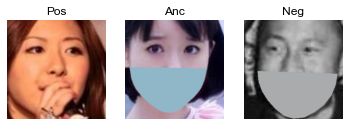

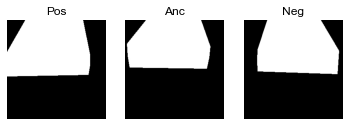

In [225]:
idx = np.random.choice(train_dataset.__len__())
sample = train_dataset[idx]
show_triplets(sample, 'img')
show_triplets(sample, 'mask')

#### Create Pair Dataset
<a id='pair'></a>
`preprocess/pair_dataset.py`

In [21]:
# 针对二元组的数据集：Image1, Image2, IsSame
class PairDataset(Dataset):
    def __init__(self, data_list='pairs.txt', img_size=256, transform=None, masked=False):
        self.data_list = data_list #基于不同数据集
        self.img_size = img_size
        self.transform = transform

        # 初始化模型
        self.detector = detector # 人脸检测模型
        self.predictor = predictor #68个关键点检测模型
         
        # 如果有配好的LFW数据就直接用，要不就生成一下
        lfw_path=os.path.join(DATA_ROOT, 
                 f"lfw_funneled_{'masked_' if masked else ''}pairs.npy")
        if os.path.exists(lfw_path):
            print("Loading LFW dataset...")
            self.pairs = np.load(lfw_path)
            print(f"LFW dataset with {self.pairs.shape[0]} pairs loaded.")
        else:
            print('Generating LFW dataset...')
            self.pairs = self.generate_pairs(lfw_path)

            
    def add_extension(self, path):
        if os.path.exists(path + '.jpg'):
            return path + '.jpg'
        elif os.path.exists(path + '.png'):
            return path + '.png'
        else:
            return None #如果不是jpg/png，跳过该pair
            
    
    def generate_pairs(self, lfw_path):
        same_pairs, diff_pairs = load_test_list(os.path.join(DATA_ROOT, self.data_list))
        pairs = []
        skip_num = 0 #记录路径不存在或检测到的人脸非1个的pairs数
        directory = os.path.splitext(lfw_path)[0].replace('_pairs','') #根据lfw_path判断是戴/不戴口罩的pairs
        for i in tqdm(range(same_pairs.shape[0])):
            name, id1, id2, _ = same_pairs.iloc[i]
            path1 = self.add_extension(os.path.join(directory, name, f'{name}_{int(id1):04}'))
            path2 = self.add_extension(os.path.join(directory, name, f'{name}_{int(id2):04}'))
            label = 1 #相同人
            if path1 and path2: #只有当路径存在
                img1 = self.get_face_align(path1) #检测人脸
                img2 = self.get_face_align(path2)
                if (img1 is not None) and (img2 is not None): #只有当检测到人脸的情况，才加入到数据集
                    pairs.append([path1, path2, label])
                    # cv2.imwrite(path1, img1) #或者直接把原图替换为正脸截图
                    # cv2.imwrite(path2, img2)
                else:
                    skip_num+=1
            else:
                skip_num+=1
                
        for i in tqdm(range(diff_pairs.shape[0])):
            name1, id1, name2, id2 = diff_pairs.iloc[i]
            path1 = self.add_extension(os.path.join(directory, name1, f'{name1}_{int(id1):04}'))
            path2 = self.add_extension(os.path.join(directory, name2, f'{name2}_{int(id2):04}'))
            label = 0 #不同人
            if path1 and path2:
                img1 = self.get_face_align(path1) #检测人脸
                img2 = self.get_face_align(path2)
                if (img1 is not None) and (img2 is not None):
                    pairs.append([path1, path2, label])
                    # cv2.imwrite(path1, img1) #或者直接把原图替换为正脸截图
                    # cv2.imwrite(path2, img2)
                else:
                    skip_num+=1 
            else:
                skip_num+=1
        
        if skip_num>0:
            print(f'Skipped {skip_num} pairs')
        pairs = np.array(pairs)
        np.random.shuffle(pairs) #因为前半部分都是1，后半都是0，需要先打乱顺序
        np.save(lfw_path, pairs)
        print(f"LFW dataset with {len(pairs)} pairs generated and saved to: {lfw_path}")
        return pairs 
    
    
    def __len__(self):
        return len(self.pairs)             
          
        
    def get_face_align(self, image_path):
        image = cv2.imread(image_path) #BGR
        face_align=None #原始值
    
        # 人脸检测，返回bbox坐标
        bboxes = self.detector(image, upsample_num_times=1) #返回bbox坐标[[(x1,y1) (x2,y2)],[...]]
        if len(bboxes) == 1:    
            # 对检测到的人脸提取人脸关键点
            landmarks = self.predictor(image, bboxes[0]) #若有多组landmarks的话，用dlib.full_objection_detections().append(landmarks)
            face_align = dlib.get_face_chip(image, face=landmarks, #关键点对齐人脸，旋转恢复水平正面
                                            size=self.img_size) #resize得到放大居中的人脸框截图
        return face_align
        
            
    def __getitem__(self, idx):
        path1, path2, label = self.pairs[idx]
        img1 = self.get_face_align(path1) #如果pairs里的路径是原图，仍然要做对齐检测，如果已做也会返回即有结果，
        img2 = self.get_face_align(path2)
        # img1 = cv2.imread(path1)
        # img2 = cv2.imread(path2)
        
        if self.transform:
            img1 = self.transform(img1) #float32 [c,h,w]
            img2 = self.transform(img2)
            
        label = torch.LongTensor([int(label)]) #int64
        return img1, img2, label

In [22]:
test_transform = transforms.Compose([
    transforms.ToTensor(), #把array/PIL从[0,255]转为[0,1]的FloatTensor [c,h,w]
    # transforms.Normalize(
    #     mean=[0.5, 0.5, 0.5],
    #     std=[0.5, 0.5, 0.5])
])

In [23]:
valid_dataset = PairDataset(img_size=256, transform = test_transform, masked=False)
valid_loader  = DataLoader(valid_dataset, shuffle=False, batch_size = BATCH_SIZE, drop_last=False, 
                      num_workers=0) 

Loading LFW dataset...
LFW dataset with 5425 pairs loaded.


In [31]:
valid_masked_dataset = PairDataset(img_size=256, transform = test_transform, masked=True)
valid_masked_loader  = DataLoader(valid_masked_dataset, shuffle=False, batch_size = BATCH_SIZE, drop_last=False, 
                      num_workers=0) 

Loading LFW dataset...
LFW dataset with 1 pairs loaded.


In [26]:
pd.DataFrame(pairs)[2].value_counts()

0    2744
1    2681
Name: 2, dtype: int64

In [15]:
# 二元组，包括A/P或A/N两张图片路径，以及label是否为同一人
VAL_LFW = 'lfw_funneled_pairs.npy'
pairs = np.load(os.path.join(DATA_ROOT, VAL_LFW))
pairs.shape
pairs[0]
pairs[3000]

(5425, 3)

array(['datasets/lfw_funneled/Christopher_Walken/Christopher_Walken_0001.jpg',
       'datasets/lfw_funneled/Christopher_Walken/Christopher_Walken_0004.jpg',
       '1'], dtype='<U102')

array(['datasets/lfw_funneled/Colin_Powell/Colin_Powell_0040.jpg',
       'datasets/lfw_funneled/Colin_Powell/Colin_Powell_0071.jpg', '1'],
      dtype='<U102')

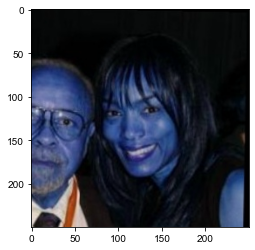

Datasets/lfw-funneled/Angela_Bassett/Angela_Bassett_0003.jpg rectangles[[(-34, 106) (66, 196)], [(76, 96) (165, 186)]]
8 

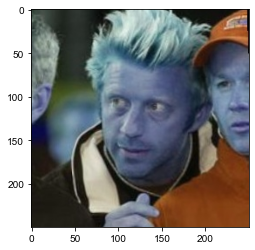

Datasets/lfw-funneled/Boris_Becker/Boris_Becker_0006.jpg rectangles[[(67, 80) (175, 187)], [(204, 66) (266, 129)]]
29 

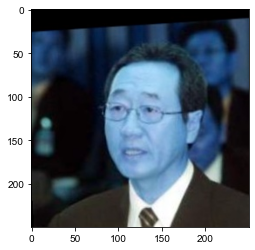

Datasets/lfw-funneled/Chang_Dae-whan/Chang_Dae-whan_0002.jpg rectangles[[(67, 80) (175, 187)], [(170, 32) (222, 84)]]
38 

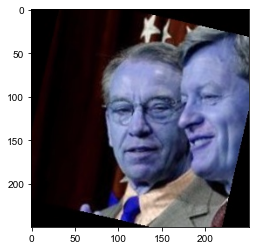

Datasets/lfw-funneled/Charles_Grassley/Charles_Grassley_0001.jpg rectangles[[(67, 80) (175, 187)], [(145, 76) (235, 166)]]
39 

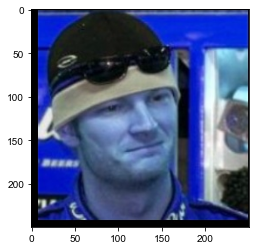

Datasets/lfw-funneled/Dale_Earnhardt_Jr/Dale_Earnhardt_Jr_0003.jpg rectangles[]
44 

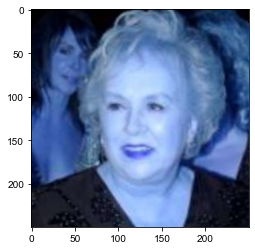

Datasets/lfw-funneled/Doris_Roberts/Doris_Roberts_0003.jpg rectangles[[(67, 80) (175, 187)], [(17, 32) (80, 94)]]
49 

In [251]:
# 检查发现dlib会检测到大量LFW图片有1个人以上人脸，甚至没有检测到人脸
# 为了后期不出现错误，修改代码在创建pairs时，跳过所有检测出非1个人脸的数据
count = 0
for i in range(valid_dataset.__len__()):
    try:
        sample = valid_dataset[i]
    except Exception as e:
        count+=1
        print(i, end=' ')
        if count>5:
            break
        else:
            continue

In [705]:
def show_pairs(sample):
    img1, img2, label = sample
    images = [img1, img2]
    plt.subplots(1,2, figsize=(5,2))
    for i in range(2):
        plt.subplot(1,2,i+1)
        img = np.transpose(images[i].numpy(), (1,2,0)) #(h,w,c)
        plt.imshow(img[...,::-1])
        plt.axis(False)
    plt.suptitle(f'Same person: {"True" if label else "False"}')
    plt.show()

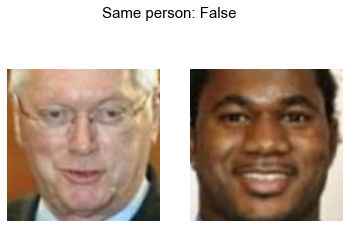

In [100]:
idx = np.random.choice(valid_dataset.__len__())
sample = valid_dataset[idx]
show_pairs(sample)

In [115]:
def get_dataset(softmax_criterion=False, att_criterion=False, masked_face=False, fusion_face=False):
    if softmax_criterion: #用softmax loss训练
        train_dataset = SingleDataset(IMAGE_SIZE, transform=train_transform, masked=masked_face,
                                        mode='train', train_size=TRAIN_SIZE)
        train_loader  = DataLoader(train_dataset, shuffle=True, batch_size = BATCH_SIZE, 
                                   drop_last=True, num_workers=num_workers, pin_memory=pin_memory) 
        valid_dataset = SingleDataset(IMAGE_SIZE, transform=test_transform, masked=masked_face, 
                                        mode='test', train_size=TRAIN_SIZE)
        valid_loader  = DataLoader(valid_dataset, shuffle=False, batch_size = BATCH_SIZE//8, 
                                   drop_last=False, num_workers=num_workers, pin_memory=pin_memory)
        return (train_dataset, train_loader), (valid_dataset, valid_loader)
    
    elif att_criterion: #用triplet和attention loss训练
        train_dataset = TripletDataset(IMAGE_SIZE, transform=train_transform, masked=masked_face, fusion=fusion_face, 
                                     mask=True, bbox=False, n_triplets=N_TRIPLETS) #有mask
        train_loader  = DataLoader(train_dataset, shuffle=True, batch_size = BATCH_SIZE, 
                                   drop_last=False,  num_workers=num_workers, pin_memory=pin_memory) #用triplet训练时，因为每个batch还需要做进一步样本筛选，不需要drop last
        valid_dataset = PairDataset(img_size=IMAGE_SIZE, transform = test_transform, masked=False)
        valid_loader  = DataLoader(valid_dataset, shuffle=False, batch_size = BATCH_SIZE//8, 
                                   drop_last=False,  num_workers=num_workers, pin_memory=pin_memory) 
        valid_masked_dataset = PairDataset(img_size=IMAGE_SIZE, transform = test_transform, masked=True)
        valid_masked_loader  = DataLoader(valid_masked_dataset, shuffle=False, batch_size = BATCH_SIZE//8, 
                                          drop_last=False,  num_workers=num_workers, pin_memory=pin_memory) 
        return (train_dataset, train_loader), (valid_dataset, valid_loader), (valid_masked_dataset, valid_masked_loader)

    else: #用triplet loss训练
        train_dataset = TripletDataset(IMAGE_SIZE, transform=train_transform, masked=masked_face, fusion=fusion_face,
                                     mask=False, bbox=False, n_triplets=N_TRIPLETS) #没有mask
        train_loader  = DataLoader(train_dataset, shuffle=True, batch_size = BATCH_SIZE, 
                                   drop_last=False,  num_workers=num_workers, pin_memory=pin_memory) 
        valid_dataset = PairDataset(img_size=IMAGE_SIZE, transform = test_transform, masked=False)
        valid_loader  = DataLoader(valid_dataset, shuffle=False, batch_size = BATCH_SIZE//8, 
                                   drop_last=False,  num_workers=num_workers, pin_memory=pin_memory) 
        valid_masked_dataset = PairDataset(img_size=IMAGE_SIZE, transform = test_transform, masked=True)
        valid_masked_loader  = DataLoader(valid_masked_dataset, shuffle=False, batch_size = BATCH_SIZE//8, 
                                          drop_last=False,  num_workers=num_workers, pin_memory=pin_memory) 
        return (train_dataset, train_loader), (valid_dataset, valid_loader), (valid_masked_dataset, valid_masked_loader)
    

In [116]:
get_dataset(softmax_criterion=False, att_criterion=True, masked_face=True)

Loading triplets dataset...
Triplets dataset with 1000 samples loaded.
Loading LFW dataset...
LFW dataset with 5425 pairs loaded.
Loading LFW dataset...
LFW dataset with 1 pairs loaded.


((<__main__.TripletDataset at 0x14b7d8d00>,
  <torch.utils.data.dataloader.DataLoader at 0x14839b040>),
 (<__main__.PairDataset at 0x14839b4c0>,
  <torch.utils.data.dataloader.DataLoader at 0x14b7d82b0>),
 (<__main__.PairDataset at 0x14b7d8af0>,
  <torch.utils.data.dataloader.DataLoader at 0x14b7d8f70>))

>### Model

#### ResNet

`model/resnet.py`

In [24]:
from torchvision import models
from torchsummary import summary

In [62]:
# 没有Attention机制的baseline
class ResNet(nn.Module):
    '''
    triplet loss: 用A/P/N的emb计算相同和不同人之间的dist，用margin对比距离差
    softmax_loss: 把人作为类别，计算cross entropy loss
    '''
    def __init__(self, name='resnet18', embedding_dim=128, n_classes=500, 
                 softmax_criterion=False, pretrained=False):
        super(ResNet, self).__init__()
        # 加载完预训练参数后，把最后一层fc重置，从1000改为emb
        self.model = self.get_resnet(name, pretrained)
        self.model.fc = nn.Linear(self.model.fc.in_features, embedding_dim)
        self.softmax = softmax_criterion
        if self.softmax: 
            self.classifier = nn.Linear(embedding_dim, n_classes) #根据这个人的emb，找到这个人
    
    def get_resnet(self, name, pretrained):
        structure = {
         'resnet18': models.resnet18,
         'resnet34': models.resnet34,
         'resnet50': models.resnet50,
         'resnet101': models.resnet101,
         'resnet152': models.resnet152
        }
        model = structure[name](pretrained=pretrained)
        return model       

    def forward(self, x):
        emb = self.model(x) #得到人脸emb (b,emb)
        # l2 normalized emb
        emb = emb/torch.norm(emb, dim=1, keepdim=True) #emb/norm(emb)
        
        #先用softmax训练，再用triplet对emb做fine tune
        if self.softmax: #用normalized emb和weight求cos(theta)，后续计算arcface loss
            self.classifier.weight.data = self.classifier.weight.data/torch.norm(self.classifier.weight.data, dim=1, keepdim=True)
            logits = self.classifier(emb) #(b,n_classes)
            return emb, logits
        else:
            return emb #测试就直接返回emb

In [168]:
model = ResNet('resnet50', softmax_criterion=True)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

#### Attention Modules

`model/attention.py`

通过CBAM的Channel Attention模块和Spatial Attention模块，让模型把注意力集中在没有被口罩遮挡的部分，对应生成的mask，使二者的距离越来越近。

In [25]:
class ChannelAttention(nn.Module):
    def __init__(self, in_chans, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1) #Squeeze (1,1,c)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        # Pooling共享Conv
        self.fc1 = nn.Conv2d(in_chans, in_chans // reduction, kernel_size=1, bias=False) #Excitation (1,1,c/r)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(in_chans // reduction, in_chans, kernel_size=1, bias=False) #(1,1,c)
        self.sigmoid = nn.Sigmoid() #每个feature的权重

    def forward(self, x):
        inputs = x
        avg_pool = self.fc2(self.relu(self.fc1(self.avg_pool(x))))
        max_pool = self.fc2(self.relu(self.fc1(self.max_pool(x))))
        x = self.sigmoid(avg_pool+max_pool)
        # x = inputs*x #加权features
        return x #attention weights，后续可视化heapmap，以及计算和mask之间的loss

In [26]:
block = ChannelAttention(128)
summary(block, (128, 4,4))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
 AdaptiveAvgPool2d-1            [-1, 128, 1, 1]               0
            Conv2d-2              [-1, 8, 1, 1]           1,024
              ReLU-3              [-1, 8, 1, 1]               0
            Conv2d-4            [-1, 128, 1, 1]           1,024
 AdaptiveMaxPool2d-5            [-1, 128, 1, 1]               0
            Conv2d-6              [-1, 8, 1, 1]           1,024
              ReLU-7              [-1, 8, 1, 1]               0
            Conv2d-8            [-1, 128, 1, 1]           1,024
           Sigmoid-9            [-1, 128, 1, 1]               0
Total params: 4,096
Trainable params: 4,096
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.01
Params size (MB): 0.02
Estimated Total Size (MB): 0.03
-----------------------------------------------

In [27]:
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1 #Same Conv
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False) 
        self.sigmoid = nn.Sigmoid() #每个pixel的权重

    def forward(self, x):
        inputs = x
        avg_pool = torch.mean(x, dim=1, keepdim=True) #(b,1,h,w)
        max_pool, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_pool, max_pool], dim=1)
        x = self.conv(x)
        x = self.sigmoid(x)
        # x = inputs*x #加权features
        return x 

In [29]:
block = SpatialAttention()
summary(block, (128, 4,4))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1              [-1, 1, 4, 4]              98
           Sigmoid-2              [-1, 1, 4, 4]               0
Total params: 98
Trainable params: 98
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [28]:
class FaceAttention(nn.Module):
    def __init__(self, in_chans, out_chans):
        super(FaceAttention, self).__init__()
        self.conv1 = nn.Conv2d(in_chans, out_chans, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_chans, out_chans, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(out_chans, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        x = self.sigmoid(x)
        return x

In [36]:
block = FaceAttention(128, 128)
summary(block, (128, 4,4))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 128, 4, 4]         147,584
              ReLU-2            [-1, 128, 4, 4]               0
            Conv2d-3            [-1, 128, 4, 4]         147,584
              ReLU-4            [-1, 128, 4, 4]               0
            Conv2d-5              [-1, 1, 4, 4]           1,153
           Sigmoid-6              [-1, 1, 4, 4]               0
Total params: 296,321
Trainable params: 296,321
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 1.13
Estimated Total Size (MB): 1.20
----------------------------------------------------------------


#### ResNet_CBAM

`model/resnet_cbam.py`

In [29]:
from torchvision.models.resnet import BasicBlock, Bottleneck #原版直接使用
from torch.utils import model_zoo

由于需要修改Block内部结构，无法直接使用`models.resnet18()`，为了同样能加载Pytorch预训练参数，可以直接从Github复制模型[source codes](https://github.com/pytorch/vision/blob/main/torchvision/models)再做修改，保证除了新结构以外，其余结构名等都不变，否则无法对应加载预训练参数。

In [30]:
class BasicBlock_CBAM(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock_CBAM, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                     padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
        
        # 在block的最后增加一个CBAM模块
        self.channel_att = ChannelAttention(planes)
        self.spatial_att = SpatialAttention()

    def forward(self, x):
        residual = x
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x = self.channel_att(x)*x
        x = self.spatial_att(x)*x
        
        if self.downsample is not None:
            residual = self.downsample(residual)
        x += residual
        x = self.relu(x)
        return x

In [31]:
class Bottleneck_CBAM(nn.Module):
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck_CBAM, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        
        # 在block的最后增加一个CBAM模块
        self.channel_att = ChannelAttention(planes * 4)
        self.spatial_att = SpatialAttention()

    def forward(self, x):
        residual = x
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = self.channel_att(x)*x
        x = self.spatial_att(x)*x

        if self.downsample is not None:
            residual = self.downsample(residual)
        x += residual
        x = self.relu(x)
        return x

In [32]:
class ResNet_CBAM(nn.Module):
    def __init__(self, block, layers, embedding_dim=128, n_classes=500, 
                 att_criterion=False, softmax_criterion=False):
        super(ResNet_CBAM, self).__init__()
        # Stem
        self.inplanes = 64 #stem后的channel
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.spatial_att = SpatialAttention() #新增att，因为后续的layer block都已经增加了CBAM模块
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # 前3个block使用attention，最后一个block使用原来的
        self.layer1 = self._make_layer(block, 64,  layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        #由于修改了结构，和预训练参数的shape会不一样，最好直接改层名，使其不会被匹配上
        self.fc_emb = nn.Linear(512 * block.expansion, embedding_dim) 
        
        # 在最后2个layer输出增加att模块，是主要用于可视化，以及检查权重和mask之间的att loss，让关注度集中在没有被遮挡的脸部区域
        self.spatial_att1 = SpatialAttention() 
        self.spatial_att2 = SpatialAttention()
        self.att_loss = AttentionLoss() 
        self.att = att_criterion #是否计算mask的att loss
        self.softmax = softmax_criterion #是否计算softmax loss
        if self.softmax: 
            self.classifier = nn.Linear(embedding_dim, n_classes) #根据这个人的emb，找到这个人
    
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, np.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion))

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x, mask=None):
        h,w = x.shape[2:]  #(b,3,h,w)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.spatial_att(x)*x
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        att1 = self.spatial_att1(x)
        x = att1*x #(b,256*expansion,14,14)
        x = self.layer4(x)
        att2 = self.spatial_att2(x)
        x = att2*x #(b,512*expansion,7,7)
        heatmap = x #后续可以给最后一层Conv画热力图
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc_emb(x)
        
        # l2 normalized emb
        emb = x/torch.norm(x, dim=1, keepdim=True) #emb/norm(emb)
        
        #先用softmax训练，再用triplet和att loss对emb做fine tune
        if self.softmax:
            #用normalized emb和weight求cos(theta)，后续计算arcface loss
            self.classifier.weight.data = self.classifier.weight.data/torch.norm(self.classifier.weight.data, dim=1, keepdim=True)
            logits = self.classifier(emb) #(b,n_classes)
            return emb, logits
        elif self.att:
            att_loss=None #初始值，只有训练的时候才计算loss
            if self.training:
                att1_loss = self.att_loss(att1, mask) #(b,h,w)
                att2_loss = self.att_loss(att2, mask)
                att_loss = att1_loss + att2_loss
            return emb, att_loss, heatmap
        else:
            return emb #如果不计算loss的话，直接返回emb

In [33]:
def get_resnet_cbam(name='resnet18', basicblock=BasicBlock_CBAM, bottleneck=Bottleneck_CBAM, 
                    embedding_dim=128, n_classes=500, att_criterion=False, softmax_criterion=False, pretrained=False):
    structure = {
        'resnet18': ResNet_CBAM(basicblock, [2,2,2,2], embedding_dim, n_classes, att_criterion, softmax_criterion),
        'resnet34': ResNet_CBAM(basicblock, [3,4,6,3], embedding_dim, n_classes, att_criterion, softmax_criterion),
        'resnet50': ResNet_CBAM(bottleneck, [3,4,6,3], embedding_dim, n_classes, att_criterion, softmax_criterion),
        'resnet101': ResNet_CBAM(bottleneck, [3,4,23,3], embedding_dim, n_classes, att_criterion, softmax_criterion),
        'resnet152': ResNet_CBAM(bottleneck, [3,8,36,3], embedding_dim, n_classes, att_criterion, softmax_criterion)}
    
    pretrained_urls = {
        'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
        'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
        'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
        'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
        'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',}
    
    model = structure[name]
    if pretrained:
        pretrained_state_dict = model_zoo.load_url(pretrained_urls[name])
        state_dict = model.state_dict()
        for key, value in pretrained_state_dict.items(): 
            if key in state_dict: #由于新模型会删除一些旧结构，不需要加载多余的参数
                state_dict[key]=pretrained_state_dict[key] #用预训练参数覆盖
        model.load_state_dict(state_dict)
    return model

In [39]:
model = get_resnet_cbam('resnet50',pretrained=False, att_criterion=True, softmax_criterion=False,
                       n_classes=3)
summary(model, [(3,256,256), (256,256)])

/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4          [-1, 1, 128, 128]              98
           Sigmoid-5          [-1, 1, 128, 128]               0
  SpatialAttention-6          [-1, 1, 128, 128]               0
         MaxPool2d-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]           4,096
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11           [-1, 64, 64, 64]          36,864
      BatchNorm2d-12           [-1, 64, 64, 64]             128
             ReLU-13           [-1, 64, 64, 64]               0
           Conv2d-14          [-1, 256,

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


TypeError: can't multiply sequence by non-int of type 'tuple'

In [93]:
image = sample['anc_img'][np.newaxis,...]
mask = sample['anc_mask'][np.newaxis,...]
# model.train()
emb, att_loss, heatmap = model(image, mask)
# emb, logits = model(image, mask)
# emb = model(image, mask)
emb.shape
# logits.shape
att_loss 
heatmap.shape

torch.Size([1, 128])

tensor([2.8409], grad_fn=<AddBackward0>)

torch.Size([1, 2048, 8, 8])

In [60]:
def get_model(name='resnet18', embedding_dim=128, n_classes=500, att_model=False, cbam=False,
             softmax_criterion=False, att_criterion=False, pretrained=False):
    if att_model: #带attention模块的ResNet
        if cbam: #用CBAM模块的block
            model = get_resnet_cbam(name, embedding_dim, n_classes, BasicBlock_CBAM, Bottleneck_CBAM, 
                                    softmax_criterion, att_criterion, pretrained)
        else:
            model = get_resnet_cbam(name, embedding_dim, n_classes, BasicBlock, Bottleneck, 
                                    softmax_criterion, att_criterion, pretrained)
    else: #不带attention
        model = ResNet(name, embedding_dim, n_classes, softmax_criterion, pretrained)
    return model 

In [63]:
EMBEDDING_DIM=128
model = get_model()
model = nn.DataParallel(model) #当gpu多于1个时，可以并行运算
model

DataParallel(
  (module): ResNet(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNor

In [47]:
def load_model_checkpoint(model, checkpoint, device):
    # 预加载自己训练的模型
    model.load_state_dict(checkpoint['state_dict'], strict=False) #加载到cpu，用softmax训练后，加载除了classifier以外的层数进行微调
    model.to(device) #分配给gpu
    return model
    

def load_optimizer_checkpoint(optimizer, checkpoint, device):
    # 继续训练会要记录上次optimizer的状况
    optimizer.load_state_dict(checkpoint['optimizer_state_dict']) #参数在cpu
    # param_groups会跟随model.to(device)而转换到gpu，但是state仍然在cpu
    for state in optimizer.state.values(): #取出里面的mementum_buffer
        print(state.keys())
        for k, v in state.items():
            state[k] = v.to(device) #再次分配到gpu
    return optimizer


def load_scheduler_checkpoint(lr_scheduler, checkpoint, device):
    # 继续训练会要记录上次lr_scheduler的状况
    lr_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    return lr_scheduler

> ### Train
<a id='history'></a>

#### Criterion
`train/criterion.py`

In [35]:
triplet_loss_criterion = nn.TripletMarginLoss(margin=0.2) # l2 norm dist

In [24]:
anc = torch.rand(2,128)
pos = torch.rand(2,128)
neg = torch.rand(2,128)
triplet_loss_criterion(anc, pos, neg)

tensor(0.3574)

In [36]:
class AttentionLoss(nn.Module):
    def forward(self, att_map, mask):
        # 得到不同层提取的att map形状：(b,1,h,w)的tensor
        h,w = att_map.shape[2:]

        # 得到和att map尺寸一样的mask：(b,h,w)的array
        mask = np.array(mask)/255 #从[0,255]转成[0,1]
        mask = torch.from_numpy(np.expand_dims(mask,1)).float() #(b,1,h,w)的float32 tensor
        mask = transforms.Resize((h,w))(mask) #可以批量操作，而cv2.resize只能对单张图片操作
        mask.to(device) #处理后再分配到gpu
        att_loss = F.binary_cross_entropy(att_map, mask, reduction='none') 
        att_loss = torch.mean(att_loss, dim=[1,2,3]) #求每个样本的loss，方便后续对样本筛选 (b,)
        return att_loss

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
att_map = torch.rand(2,1,3,3)
mask = np.random.rand(2,5,5)
att_loss_criterion = AttentionLoss()
att_loss_criterion(att_map, mask) #(b,)

tensor([1.1979, 1.1162])

In [38]:
class ArcFaceLoss(nn.Module):
    def __init__(self, margin=0.5, scale=10):
        super(ArcFaceLoss, self).__init__()
        self.margin=margin
        self.scale=scale
        
    def forward(self, y_pred, y_true):
        y_pred = torch.clip(y_pred, -1,1) #logit=cos(theta)，先截取范围
        label_onehot = F.one_hot(y_true)
        logits, _ = torch.max(y_pred*label_onehot, axis=1, keepdim=True) # 利用one hot找到每个样本正确类别下的logit (b,)
        theta = torch.arccos(logits) #通过logit=cos(theta)得到theta
        y_pred = (torch.cos(theta + self.margin) - logits)*label_onehot + y_pred #把对应类别的logit从cos(theta)替换为cos(theta+m)
        y_pred = y_pred * self.scale #乘上伸缩系数
        loss = F.cross_entropy(y_pred, y_true) #样本平均loss
        return loss

In [789]:
y_pred = torch.rand(10,3)
y_true = torch.from_numpy(np.random.choice(3, 10))
arcface_loss_criterion = ArcFaceLoss() 
arcface_loss_criterion(y_pred, y_true)

tensor(6.2366)

#### Optimizer
`train/optimizer.py`

In [41]:
from torch import optim

In [ ]:
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 5e-4

In [42]:
def get_optimizer(model, name='adam'):
    if name=='sgd':
        optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()),
                      lr=LEARNING_RATE, momentum=0.9, weight_decay=WEIGHT_DECAY)
    elif name=='adam':
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                      lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    elif name=='adagrad':
        optimizer = optim.Adagrad(filter(lambda p: p.requires_grad, model.parameters()),
                      lr =LEARNING_RATE, lr_decay=1e-4, weight_decay=WEIGHT_DECAY)
    return optimizer

In [43]:
optimizer = get_optimizer(model)

In [44]:
# def adjust_learning_rate(optimizer, epoch):
#     if epoch<30:
#         lr =  0.125
#     elif (epoch>=30) and (epoch<60):
#         lr = 0.0625
#     elif (epoch >= 60) and (epoch < 90):
#         lr = 0.0155
#     elif (epoch >= 90) and (epoch < 120):
#         lr = 0.003
#     elif (epoch>=120) and (epoch<160):
#         lr = 0.0001
#     else:
#         lr = 0.00006
#     for param_group in optimizer.param_groups:
#         param_group['lr'] = lr
#     return lr

def adjust_learning_rate(optimizer, epoch):
    if epoch<2:
        lr = 1e-4
    elif (epoch>=2) and (epoch<5):
        lr = 1e-5
    elif (epoch>=5) and (epoch<8):
        lr = 1e-6
    elif (epoch>=8) and (epoch<10):
        lr = 1e-7
    elif epoch>=10:
        lr = 1e-8
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

In [ ]:
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

#### Metrics
`train/metrics.py`

In [45]:
from sklearn.metrics import auc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
from scipy import interpolate
import imageio
from IPython.display import Image as IPyImage

In [46]:
def confusion_matrix_multi(y_pred, y_true): #用概率更高值来决定多分类类别
    y_pred = torch.argmax(y_pred, axis=1)
    y_pred = y_pred.detach().numpy()
    y_true = y_true.detach().numpy()
    acc = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average='macro',zero_division=0) #由于存在imbalanced
    precision = precision_score(y_true, y_pred, average='macro',zero_division=0) 
    f1 = f1_score(y_true, y_pred, average='macro',zero_division=0)
    metrics = {'precision':precision, 'recall':recall, 'acc':acc, 'f1':f1}
    return metrics

In [47]:
def confusion_matrix_dist(dist, y_true, threshold=0.5, beta=1):
    '''
    Parameters
    ----------
    beta (int): when beta>1, recall-oriented; 
                when beta<1, precision-oriented
    '''
    y_pred = dist<threshold #用阈值来决定类别
    tp = np.logical_and(y_true==1, y_pred==1).sum()
    fp = np.logical_and(y_true==0, y_pred==1).sum()
    tn = np.logical_and(y_true==0, y_pred==0).sum()
    fn = np.logical_and(y_true==1, y_pred==0).sum()
    
    fpr = 0 if (tn+fp)==0 else fp/(tn+fp)
    precision = 0 if (tp+fp)==0 else tp/(tp+fp)
    recall = 0 if (tp+fn)==0 else tp/(tp+fn) 
    acc = (tp+tn)/(tp+fp+tn+fn)
    f1 = (1+beta**2)*tp/((1+beta**2)*tp+fn+fp)
    metrics = {'fpr':fpr, 'precision':precision, 'recall':recall, 'acc':acc, 'f1':f1}
    return metrics


def calculate_roc(distances, labels, n_folds=10):
    thresholds = np.arange(min(distances), max(distances), 0.001) #根据dist生成用于遍历的阈值
    indices = np.arange(len(labels)) #samples idx
    n_thresholds = len(thresholds) #遍历的thresholds数
    kfold = StratifiedKFold(n_splits=n_folds, shuffle=False) #10折交叉验证
    tpr = np.zeros((n_folds, n_thresholds))
    fpr = np.zeros((n_folds, n_thresholds))
    acc = np.zeros((n_folds, n_thresholds))
    precision = np.zeros(n_folds)
    recall = np.zeros(n_folds)
    best_thres = np.zeros(n_folds)
    
    for fold_i, (train_idx, test_idx) in enumerate(kfold.split(indices, labels)): #分成10折的indices
        # 求得在目标acc(最高)下的对应阈值
        for thres_i, thres in enumerate(thresholds):
            metrics = confusion_matrix_dist(distances[train_idx], labels[train_idx], thres)
            acc[fold_i, thres_i] = metrics['acc']
        best_thres_idx = np.argmax(acc, axis=1)[fold_i] 

        # 求得该阈值下的metrics和平均tpr/fpr
        for thres_i, thres in enumerate(thresholds):
            metrics = confusion_matrix_dist(distances[test_idx], labels[test_idx], thres)
            tpr[fold_i, thres_i] = metrics['tpr']
            fpr[fold_i, thres_i] = metrics['fpr']
        metrics = confusion_matrix_dist(distances[test_idx], labels[test_idx], thresholds[best_thres_idx])
        precision[fold_i] = metrics['precision']    
        recall[fold_i] = metrics['recall']
        best_thres[fold_i] = thresholds[best_thres_idx]
    acc = np.max(acc, axis=1) #(n_folds,) 每个折的最大值
    tpr = np.mean(tpr, axis=0) #(n_thresholds,) 10折下遍历threshold的平均值
    fpr = np.mean(fpr, axis=0)
    metrics_cv = {'tpr':tpr, 'fpr':fpr,'precision':precision, 'recall':recall, 'acc':acc, 'thres':best_thres}
    return metrics_cv


def calculate_tpr_fpr(distances, labels, fpr_target=1e-3, n_folds=10):
    thresholds = np.arange(min(distances), max(distances), 0.001) #根据dist生成用于遍历的阈值
    indices = np.arange(len(labels)) #samples idx
    n_thresholds = len(thresholds) #遍历的thresholds数
    kfold = StratifiedKFold(n_splits=n_folds, shuffle=False) #10折交叉验证

    tpr = np.zeros(n_folds) #TAR (True Accept Rate): 摄像头前的人通过人脸识别系统的概率，即TPR
    fpr = np.zeros(n_folds) #FAR

    for fold_i, (train_idx, test_idx) in enumerate(kfold.split(indices, labels)): #分成10折的indices
        FPR = np.zeros(n_thresholds)
        for thres_i, thres in enumerate(thresholds):
            metrics = confusion_matrix_dist(distances[train_idx], labels[train_idx], thres)
            FPR[thres_i] = metrics['fpr']
        
        # 求得在目标fpr下的对应阈值
        f = interpolate.interp1d(FPR, thresholds, kind= 'slinear') #得到threshold=f(fpr)的函数关系
        if np.min(FPR) > fpr_target:
            fpr_target = np.min(FPR)
            print(f'FPR target -> {fpr_target:.4f}')
        thres = f(fpr_target) 

        # 求得该阈值下的metrics
        metrics = confusion_matrix_dist(distances[test_idx], labels[test_idx], thres)
        tpr[fold_i] = metrics['tpr'] 
        fpr[fold_i] = metrics['fpr']
        
    return tpr, fpr

In [48]:
#对valid_loader做10折交叉验证
def evaluate_metrics(distances, labels, epoch, fpr_target=1e-3, n_folds=10, plot=True, valid_set='LFW_Unmasked'):    
    #总体评价：找到acc最高时的dist threshold，得到平均tpr/fpr/auc和每折下的precision/recall/acc/thres
    metrics_cv = calculate_roc(distances, labels, n_folds)
    tpr = metrics_cv['tpr'] #(n_thresholds,)
    fpr = metrics_cv['fpr']
    roc_auc_score = auc(fpr, tpr)
    metrics_cv['auc']=roc_auc_score
    if plot:
        plot_roc(fpr, tpr, roc_auc_score, epoch, valid_set)
    
    #目标评价：找到target fpr时的dist threshold，得到每折下的tpr/fpr，为区分用tar/far表示
    tar, far = calculate_tpr_fpr(distances, labels, fpr_target, n_folds)
    metrics_cv['tar']=tar
    metrics_cv['far']=far
    return metrics_cv


def plot_roc(fpr, tpr, roc_auc_score, epoch, valid_set='LFW_Unmasked', roc_dir=''):
    plt.figure()
    plt.plot(fpr, tpr, lw=2)
    plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve (Epoch {epoch} @ AUC = {roc_auc_score:.2%})')
    plt.gca().set_aspect('equal')
    plt.savefig(os.path.join(roc_dir, f'epoch{epoch:02}_{valid_set}_auc_{roc_auc_score:.0%}.png'))
    plt.show()

In [79]:
def generate_rou_gif(rou_dir=''):
    for valid_set in ['LFW_Unmasked', 'LFW_Masked']:
        filenames = glob.glob(os.path.join(rou_dir,f'epoch*_{valid_set}_auc_*.png')) #完整路径，同时避免.DS_stores等隐藏文件
        filenames = sorted(filenames) #确保按顺序
        plots = []
        for filename in filenames:
            image = plt.imread(filename)
            image = (image*255).astype('uint8')
            plots.append(image)
        imageio.mimsave(os.path.join(rou_dir, f'roc_{valid_set}.gif'), plots, 'GIF-FI', fps=2)
        display(IPyImage(open(os.path.join(rou_dir, f'roc_{valid_set}.gif'), 'rb').read())) #显示动画

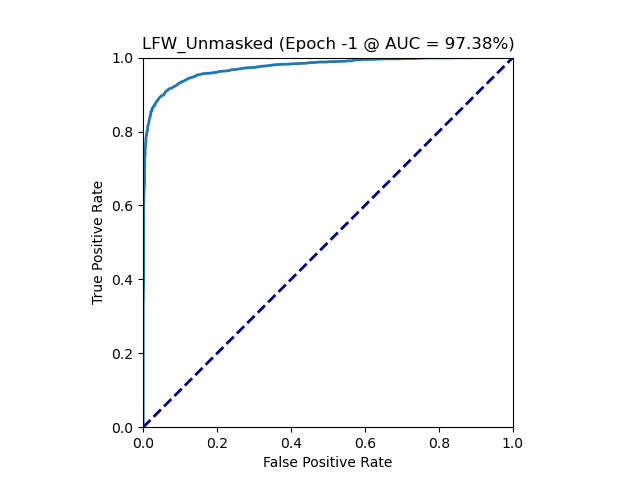

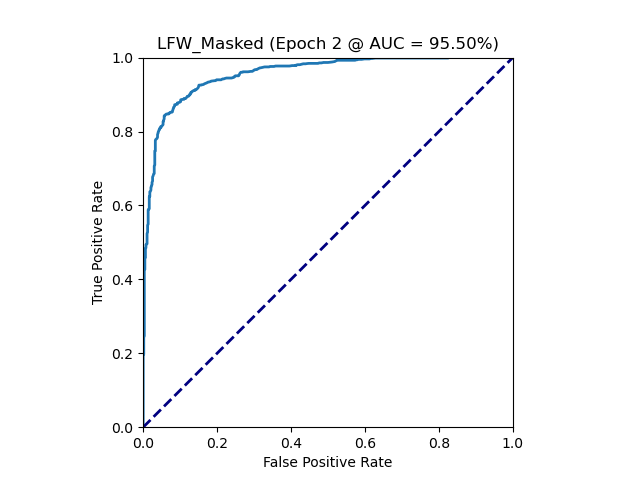

In [80]:
generate_rou_gif('note')

#### Visualization
`train/heatmap.py`

In [49]:
def prepare_heatmap(image, feature_map): #(3,h,w) (c,h,w)
    # 对最后一个Conv层可视化时，从channel方向求每个pixel的feature均值，再默认取第一个样本的结果
    h,w = image.shape[1:]  
    heatmap = torch.mean(feature_map, dim=0) #综合各channel的feature map (h,w)
    heatmap = (heatmap - torch.min(heatmap))/(torch.max(heatmap)-torch.min(heatmap)) #normalize [0,1]
    heatmap = (heatmap*255).to(torch.uint8) #[0,255]
    heatmap = cv2.resize(heatmap.detach().numpy(), (h,w)) #放大到原图大小数组
    heatmap = np.clip(heatmap, 0, 255) #保证取值范围
    image = (image*255).to(torch.uint8).detach().numpy() #转为[0,255]数组
    image = np.transpose(image, [1,2,0])[...,::-1] # (h,w,3)的RGB
    return image, heatmap

In [50]:
def plot_heatmap(img1, img2, map1, map2, dist, label, epoch, heatmap_dir=''): #(3,h,w) (c,h,w)
    # 对最后一个Conv层可视化时，从channel方向求每个pixel的feature均值，再默认取第一个样本的结果
    img1, map1 = prepare_heatmap(img1, map1)
    img2, map2 = prepare_heatmap(img2, map2)

    f,ax = plt.subplots(2,1, figsize=(6,5))
    # 图1：原图
    ax[0].imshow(cv2.hconcat([img1, img2]))
    ax[0].set_title(f"Predicted dist: {dist:.3f}, Same: {label}",fontsize=13)
    ax[0].axis('off')

    # 图2：混合原图和最后一层atention
    map1 = cv2.applyColorMap(map1, cv2.COLORMAP_JET) #叠加时两张图需要相同维度，因此需要给map分配颜色，变成(h,w,3)
    map2 = cv2.applyColorMap(map2, cv2.COLORMAP_JET) #HOT/JET都可以
    #alpha/beta是两张图片的比例，gamma是在叠合图上额外加的像素值
    superimposed1 = cv2.addWeighted(src1=img1, alpha=0.7, src2=map1, beta=0.2, gamma=0.0)
    superimposed2 = cv2.addWeighted(src1=img2, alpha=0.7, src2=map2, beta=0.2, gamma=0.0)
    ax[1].imshow(cv2.hconcat([superimposed1, superimposed2]))
    ax[1].set_title("Model Attention on the Last Conv Layer", fontsize=13)
    ax[1].axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(heatmap_dir, f'epoch{epoch:02}_heatmap.png'))
    # plt.show()

In [77]:
def generate_heatmap_gif(heatmap_dir=''):
    filenames = glob.glob(os.path.join(heatmap_dir,f'epoch*heatmap.png')) #完整路径，同时避免.DS_stores等隐藏文件
    filenames = sorted(filenames) #确保按顺序
    plots = []
    for filename in filenames:
        image = plt.imread(filename)
        image = (image*255).astype('uint8')
        plots.append(image)
    imageio.mimsave(os.path.join(heatmap_dir, f'heatmap.gif'), plots, 'GIF-FI', fps=2)
    display(IPyImage(open(os.path.join(heatmap_dir, f'heatmap.gif'), 'rb').read())) #显示动画

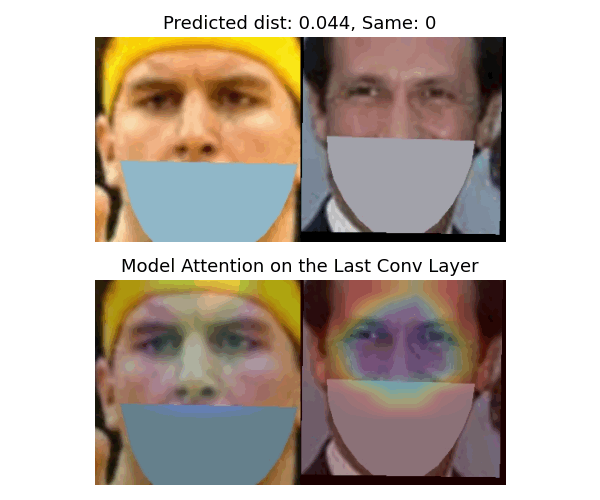

In [78]:
generate_heatmap_gif('note')

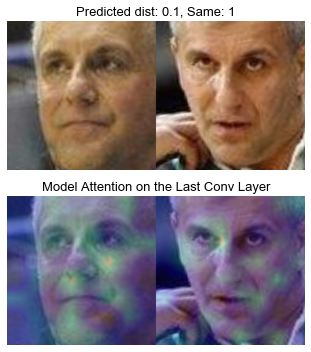

In [425]:
img1 = sample['anc_img']
img2 = sample['pos_img']
map1 = torch.rand(512,8,8)
map2 = torch.rand(512,8,8)
plot_heatmap(img1, img2, map1, map2, 0.1, 1)

#### Train on Softmax Loss
`train/train_softmax_loss.py`  
<a id='softmax'></a>
Train and validate on [Single Dataset](#single)

实际训练过程中遇到的问题：
1. 用CPU训练时，每个batch加载耗时1s，训练60-70s，速度过慢：
    - 换成V100 GPU后，配上num_workers=4，加速到0.003加载数据，0.16s训练!!
    - 但是batch size不能超过30，否则就会内存溢出

2. 用masked face搭配scale=10，训练5个epoch，每个epoch有3794次迭代，但持续得到恒定6左右的ArcFace loss，以及0.003的acc，明显无法优化难以收敛，分析可能原因：
    - 学习率太高：原来使用Adam搭配0.125学习率，先改用1e-4对前2个epoch做warm up，后续再恢复原来的schedule
    - scale不够大，导致难以收敛：把scale升到30，在2个epoch内ArcFace loss从22下降到6.4，acc明显提升到0.823，且val acc为0.832，证明提高scale有助于收敛
    - masked face比较难训练，改用unmasked face训练：在相同的scale=30下，二者均在2个epoch内，取得类似的val acc，unmasked为0.835，证明可以分别用二者训练对比

3. 训练到第3个epoch后，对于任意数据集/scale，从第二个batch开始Arcface loss突然变成nan，acc跌到0.003，后面都变无效训练，分析可能原因：
    - 学习率太高：放弃原来的lr scheduler，延续初始的小学习率，后续也沿用更小的lr进行训练。但是第3个epoch若继续用1e-4，到了epoch末尾再次变成nan，因此需要进一步减小，根据训练的情况，不断基于上一次训练得到的最优模型，逐步总结出最优的lr scheduelr
    - 由于前2个epoch已经取得不错成绩，感觉不需要训练太多epochs，为了防止后续用adam难以收敛，从一开始就直接改用sgd，但是对比发现优化速度大大减慢，第1个epoch后acc只到0.006，因此再次改回Adam。

4. 训练5个epoch后发现，虽然分类任务的train/val acc都从Epoch2的0.82/0.83快速上升到0.97/0.90左右，但是在LFW的验征集上，Epoch2的auc最高，后续3个epochs虽然lr更小，但是反而逐步下降，不戴口罩和戴口罩的LFW的auc分别从0.964/0.955慢慢下降到0.959/0.948：
    - 尝试前2个epoch用Adam，后面用sgd，帮助模型收敛，不会来回晃荡：结果显示，虽然分类任务进步缓慢，只上升到0.94/0.88，但是在LFW上的auc不会进一步衰减，但是也没有明显进步，维持在0.965/0.955左右
    - 后续尝试用best acc模型和best auc模型，进一步用triplet loss微调，看哪个效果更好

以上Softmax训练，都是反复用不同方式训练5个epochs左右得到[Evaluation](#evaluation)的结果。

In [51]:
from collections import defaultdict
import time

In [182]:
# 先用模型预测emb，然后通过计算dist找到会产生triplet loss的样本
def train_on_epoch(model, train_loader, optimizer, device, iter_smooth=1):
    epoch_loss = 0
    epoch_acc = 0
    n_batches = len(train_loader)
    # start = time.time()
    for i, (image, label) in enumerate(train_loader):
        model.train() #训练模式
        image = image.to(device) #(b,c,h,w)
        label = label.to(device).view(-1) #(b,)
        # print(f'Loading time: {time.time()-start}')
        
        # start = time.time()
        # 计算emb和softmax loss
        emb, y_pred  = model(image) #(b,128), (b,500)
        loss = arcface_loss_criterion(y_pred, label)
        metrics = confusion_matrix_multi(y_pred, label)
        acc = metrics['acc']
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # print(f'Processing time: {time.time()-start}')
        epoch_loss += loss.item()
        epoch_acc += acc
        if i%iter_smooth==0:
            print(f'Batch {i+1}/{n_batches} - Arcface loss: {epoch_loss/(i+1):.4f} - acc: {epoch_acc/(i+1):.4f}') 
        # start = time.time()
    
    #仅在drop last的时候有效，否则求loss时reduction=‘none'，再除以样本总数
    epoch_loss /= n_batches 
    epoch_acc /= n_batches 
    return epoch_loss, epoch_acc

In [127]:
def val_on_epoch(model, valid_loader, device):
    predictions, labels = [], []
    val_loss = 0
    n_samples = 0
    for i, (image, label) in enumerate(valid_loader):
        model.eval() #预测模式，关闭dropout和bn
        image = image.to(device)
        label = label.to(device)
        n_samples += image.shape[0]
        with torch.no_grad():
            emb, y_pred  = model(image) 
            label = label.view(-1) #(b,)
            #由于val batch没有drop last，先求样本loss总和，再求样本loss均值
            #arcface loss只是为了进一步优化，验证时用正常softmax
            loss = F.cross_entropy(y_pred, label, reduction='sum')  
            val_loss += loss.item() #样本loss总和
            
            #记录下来一次性计算acc
            predictions.append(y_pred.detach().cpu()) 
            labels.append(label.detach().cpu())
    
    predictions = torch.cat(predictions) #(m,2)
    labels = torch.cat(labels) #(m,)
    val_loss /= n_samples #样本loss均值
    metrics = confusion_matrix_multi(predictions, labels) 
    acc = metrics['acc']
    precision = metrics['precision']
    recall = metrics['recall']
    print(f'Validation - loss: {val_loss:.4f} - acc: {acc:.4f} - precision: {precision:.4f} - recall: {recall:.4f}')   
    return val_loss, acc, precision, recall

In [128]:
def train(model, train_loader, valid_loader=None, epochs=2):
    metrics = defaultdict(list)
    max_acc = 0.0
    # start = time.time() #计时
    for e in range(epochs):        
        print(f'Epoch {e+1}/{epochs}')
        # 根据epoch先调整lr
        adjust_learning_rate(optimizer, e)
        
        # 训练
        train_loss, train_acc = train_on_epoch(model, train_loader, optimizer, device)
        metrics['train_loss'].append(train_loss)
        metrics['train_acc'].append(train_acc)
        
        # 验证
        if valid_loader:
            val_loss, val_acc = val_on_epoch(model, valid_loader, device)
            metrics['val_loss'].append(val_loss)
            metrics['val_acc'].append(val_acc)
            
            if val_acc > max_acc:
                max_acc = val_acc #更新最大acc值
                ckpt_path = os.path.join('checkpoint', f'global_max_acc_model_{EMBEDDING_DIM}.pth') #仅保存一个最优模型
                torch.save({
                    'epoch':e+1, 
                    'acc': val_acc,
                    'loss':val_loss,
                    'model':type(model.module).__name__,
                    'state_dict': model.module.state_dict(), #模型参数w/b信息
                    'optimizer_state_dict': optimizer.state_dict(), #包括bn的running mean和std等信息
                }, ckpt_path)
                print(f'Saving epoch {e+1} max acc model: {max_acc:.4f}\n')
    return metrics

In [211]:
train(model, train_loader, train_loader)

Epoch 1/2
Batch 1/1 - Arcface loss: 1.0983 - acc: 0.3333
Validation - loss: 1.0998 - acc: 0.3333
Saving epoch 1 max acc model: 0.3333

Epoch 2/2
Batch 1/1 - Arcface loss: 1.0956 - acc: 0.3000
Validation - loss: 1.0994 - acc: 0.3333


defaultdict(list,
            {'train_loss': [1.0982550382614136, 1.0955697298049927],
             'train_acc': [0.3333333333333333, 0.3],
             'val_loss': [1.099795150756836, 1.0993968963623046],
             'val_acc': [0.3333333333333333, 0.3333333333333333]})

#### Train on Triplet Loss
`train/train_triplet_loss.py`

Train on [Triplet Dataset](#triplet) and validate on [LFW Dataset](#pair)

In [52]:
from torch.nn.modules.distance import PairwiseDistance

In [53]:
# 先用模型预测emb，然后通过计算dist找到会产生triplet loss的样本
def train_on_epoch(model, train_loader, optimizer, device, iter_smooth = 1):
    epoch_triplet_loss = 0
    n_samples = 0
    n_batches = len(train_loader)
    # start = time.time()
    for i, sample in enumerate(train_loader):
        model.train() #训练模式
        anc_img = sample['anc_img'].to(device) #(b,c,h,w)
        pos_img = sample['pos_img'].to(device)
        neg_img = sample['neg_img'].to(device)
        # print(f'Loading time: {time.time()-start}')
        
        # start = time.time()
        # 计算emb, triplet和attention loss
        anc_emb = model(anc_img) #(b,128), (b,)
        pos_emb = model(pos_img)
        neg_emb = model(neg_img)
        anc_emb *= 10 # 伸缩性系数 https://arxiv.org/pdf/1703.09507.pdf
        pos_emb *= 10 
        neg_emb *= 10 
        
        # 寻找困难样本OHNM：emb距离差比margin小的样本，即会产生triplet loss的样本
        pos_dist = PairwiseDistance(2).forward(anc_emb, pos_emb) #(b,)
        neg_dist = PairwiseDistance(2).forward(anc_emb, neg_emb)
        hard_idx = torch.where((neg_dist - pos_dist)<0.2) #得到对应样本的idx
        n_hard = len(hard_idx[0])
        
        # 如果没有困难样本，寻找下一个batch
        if n_hard == 0:
            print(f'Skipping Batch {i+1}/{n_batches} due to no hard samples.')
            continue
        
        # 筛选困难样本
        anc_emb = anc_emb[hard_idx]
        pos_emb = pos_emb[hard_idx]
        neg_emb = neg_emb[hard_idx]

        # 损失
        triplet_loss = triplet_loss_criterion(anc_emb, pos_emb, neg_emb) #(b,128)->(1,)
        optimizer.zero_grad()
        triplet_loss.backward()
        optimizer.step()
        
        # 该batch所有hard样本的loss总和
        n_samples += n_hard
        epoch_triplet_loss += triplet_loss.item()*n_hard 
        
        # print(f'Processing time: {time.time()-start}')
        if i%iter_smooth==0:
            print(f'Batch {i+1}/{n_batches} - hard samples: {n_hard} - triplet loss: {epoch_triplet_loss/n_samples:.4f}') 
        # start = time.time()
        
    epoch_triplet_loss = 0 if n_samples==0 else epoch_triplet_loss/n_samples #平均样本loss
    return epoch_triplet_loss, n_hard

In [54]:
def val_on_epoch(model, valid_loader, device, epoch, masked=False):
    distances, labels = [], []
    val_loss = 0
    n_samples = 0
    for i, (img1, img2, label) in enumerate(valid_loader):
        model.eval() #预测模式，关闭dropout和bn
        img1 = img1.to(device) #(b,c,h,w)
        img2 = img2.to(device)
        label = label.to(device)
        n_samples += img1.shape[0]
        with torch.no_grad():
            img1_emb = model(img1) #(b,128)
            img2_emb = model(img2)
            dist = PairwiseDistance(2).forward(img1_emb, img2_emb) #(b,)
            label = label.view(-1) #(b,)
            #记录下来一次性计算acc
            distances.append(dist.detach().cpu().numpy()) 
            labels.append(label.detach().cpu().numpy())
    
    # 不同验证集：戴口罩和不戴口罩
    distances = np.concatenate(distances) #(m,)
    labels = np.concatenate(labels)
    metrics = evaluate_metrics(distances, labels, epoch, plot=True, 
                               valid_set=f"LFW_{'Masked' if masked else 'Unmasked'}") 
    auc = metrics['auc'] #平均auc
    acc = metrics['acc'] #10折acc, precision, recall,tar
    tar = metrics['tar'] #tar@far=target
    thres = metrics['thres'] #10折最高acc下的阈值
    print(f'Validation - auc: {auc:.4f} - acc: {np.mean(acc):.4f}(+-{np.std(acc):.2f}) '\
          f'- tpr: {np.mean(tar):.4f}(+-{np.std(tar):.2f}) '\
          f'- dist thres: {np.mean(thres):.4f}(+-{np.std(thres):.2f})') 
    return auc, np.mean(acc)

In [55]:
def train(model, train_loader, valid_loader=None, valid_masked_loader=None, epochs=10):
    metrics = defaultdict(list)
    max_auc = 0.0
    start = time.time() #计时
    for e in range(epochs):        
        print(f'Epoch {e+1}/{epochs}')
        # 根据epoch先调整lr
        adjust_learning_rate(optimizer, e)
        
        # 训练
        train_triplet_loss, n_hard = train_on_epoch(model, train_loader, optimizer, device)
        metrics['train_triplet_loss'].append(train_triplet_loss)
        
        # 同时在戴口罩和不戴口罩的LFW上验证
        if valid_loader and valid_masked_loader:
            val_auc, val_acc = val_on_epoch(model, valid_loader, device, e, masked=False)
            metrics['val_auc'].append(val_auc)
            metrics['val_acc'].append(val_acc)
            
            val_masked_auc, val_masked_acc = val_on_epoch(model, valid_loader, device, e, masked=True)
            metrics['val_masked_auc'].append(val_masked_auc)
            metrics['val_masked_acc'].append(val_masked_acc)
            
            # 遮挡状态下的人脸识别系统，是为了能准确识别不戴口罩的人脸的前提下，提高识别戴口罩人脸的准确率
            # 因此需要平衡二者的表现，取二者均值auc为保存模型的标准
            mean_auc = np.mean([val_auc, val_masked_auc]) 
            if mean_auc > max_auc:
                max_auc = mean_auc #更新最大auc值
                ckpt_path = os.path.join(checkpoint_dir, f'global_max_auc_model_{EMBEDDING_DIM}.pth') #仅保存一个最优模型
                torch.save({
                    'epoch':e+1, 
                    'acc':[val_acc, val_masked_acc],
                    'auc':[val_auc, val_masked_auc],
                    'model':type(model.module).__name__,
                    'state_dict': model.module.state_dict(), #模型参数w/b信息
                    'optimizer_state_dict': optimizer.state_dict(), #包括bn的running mean和std等信息
                }, ckpt_path)
                print(f'Saving epoch {e+1} max auc model: {mean_auc:.4f}\n')
    return metrics

Epoch 1/2
Batch 1/34 - hard samples: 21 - triplet loss: 0.3562


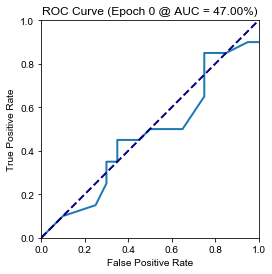

Validation - auc: 0.4700 - acc: 0.5370(+-0.02) - tpr: 0.0000(+-0.00) - dist thres: 0.0085(+-0.00)


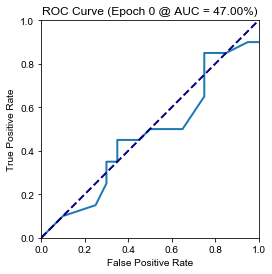

Validation - auc: 0.4700 - acc: 0.5370(+-0.02) - tpr: 0.0000(+-0.00) - dist thres: 0.0085(+-0.00)
Saving epoch 1 max auc model: 0.4700

Epoch 2/2
Batch 1/34 - hard samples: 13 - triplet loss: 0.4064


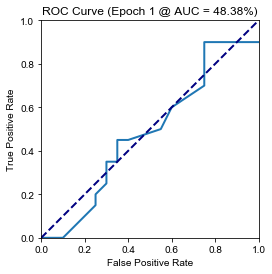

Validation - auc: 0.4838 - acc: 0.5556(+-0.02) - tpr: 0.0000(+-0.00) - dist thres: 0.0171(+-0.01)


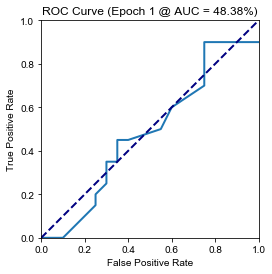

Validation - auc: 0.4838 - acc: 0.5556(+-0.02) - tpr: 0.0000(+-0.00) - dist thres: 0.0171(+-0.01)
Saving epoch 2 max auc model: 0.4838



defaultdict(list,
            {'train_triplet_loss': [0.3562101125717163, 0.4063716530799866],
             'val_auc': [0.47, 0.48375],
             'val_acc': [0.537037037037037, 0.5555555555555556],
             'val_masked_auc': [0.47, 0.48375],
             'val_masked_acc': [0.537037037037037, 0.5555555555555556]})

In [339]:
train(model, train_loader, valid_loader, valid_masked_loader, epochs=2)

#### Train on Triplet and Attention Loss
`train/train_triplet_att_loss.py`

Train on [Triplet Dataset](#triplet) with mask and validate on [LFW Dataset](#pair)

实际训练过程中遇到的问题：
1. 训练1000组多个epochs搭配emb scale=10，loss从1左右下降到0.2后，LFW结果稳定维持在auc acc 0.6左右没有变化:
    - 训练样本不够多，从1000组升到5k组，但是结果同上
    - scale可能不够大，从10上涨到30后，loss从3左右下降到0.4 triplet和1.7 att，看似有希望，然而结果依然同上
    - 样本不够复杂，用fusion混合mask和unmasked版本的triplets，然而结果依然如上
    - 用Softmax预训练参数为起点进行训练，看下文

2. 加载Softmax预训练参数，或者scale上涨之后，还没有开始训练就直接爆16G的显存：
    - 显存占用 = 模型自身参数×n + batch size×输出参数量×2 + batch input，其中n是根据优化算法来定的，如果选用SGD则n=2，如果选择Adam则n=4，由于是进一步优化选择sgd
    - 降低batch size，从32减到10才终于不爆显存
    - 梯度累加，相当于扩大batch size再进行优化，搭配上述小batch size使用，每3个steps才做一次backprob
    - 把预训练参数float32转为float16，同时转换input格式，用半精度进行训练，但是途中出现比较多其他问题，先待定
    - 删除运算中不需要的tensor，再用gc.collect()等释放显存

3. 在margin=0.2的情况下，几乎跳过所有batch，每个epoch只有10个左右的困难样本，而且微调后结果比原来的更差，估计是被那几个困难样本过拟合导致泛化性变差：
    - 把triplets换成fusion版本，增加AP距离
    - 尝试OHNM筛选困难样本

In [52]:
from torch.nn.modules.distance import PairwiseDistance

In [53]:
# 先用模型预测emb，然后通过计算dist找到会产生triplet loss的样本，再用mask计算attention loss
def train_on_epoch(model, train_loader, optimizer, device, iter_smooth = 1):
    epoch_triplet_loss, epoch_att_loss = 0, 0
    n_samples = 0
    n_batches = len(train_loader)
    # start = time.time()
    for i, sample in enumerate(train_loader):
        model.train() #训练模式
        anc_img = sample['anc_img'].to(device) #(b,c,h,w)
        pos_img = sample['pos_img'].to(device)
        neg_img = sample['neg_img'].to(device)
        anc_mask = sample['anc_mask'] #(b,h,w),由于是array，无法to(device)
        pos_mask = sample['pos_mask']
        neg_mask = sample['neg_mask']
        # print(f'Loading time: {time.time()-start}')
        
        # start = time.time()
        # 计算emb, triplet和attention loss
        anc_emb, anc_att_loss, _ = model(anc_img, anc_mask) #(b,128), (b,)
        pos_emb, pos_att_loss, _ = model(pos_img, pos_mask)
        neg_emb, neg_att_loss, _ = model(neg_img, neg_mask)
        anc_emb *= 10 # 伸缩性系数 https://arxiv.org/pdf/1703.09507.pdf
        pos_emb *= 10 
        neg_emb *= 10 
        
        # 寻找困难样本OHNM：emb距离差比margin小的样本，即会产生triplet loss的样本
        pos_dist = PairwiseDistance(2).forward(anc_emb, pos_emb) #(b,)
        neg_dist = PairwiseDistance(2).forward(anc_emb, neg_emb)
        hard_idx = torch.where((neg_dist - pos_dist)<0.2) #得到对应样本的idx
        n_hard = len(hard_idx[0])
        
        # 如果没有困难样本，寻找下一个batch
        if n_hard == 0:
            print(f'Skipping Batch {i+1}/{n_batches} due to no hard samples.')
            continue
        
        # 筛选困难样本
        anc_emb = anc_emb[hard_idx]
        pos_emb = pos_emb[hard_idx]
        neg_emb = neg_emb[hard_idx]
        anc_att_loss = anc_att_loss[hard_idx] #(b,)
        pos_att_loss = pos_att_loss[hard_idx]
        neg_att_loss = neg_att_loss[hard_idx]

        # 损失
        triplet_loss = triplet_loss_criterion(anc_emb, pos_emb, neg_emb) #(b,128)->(1,)
        att_loss = torch.mean(torch.cat([anc_att_loss, pos_att_loss, neg_att_loss])) #(3b,)->(1,)
        loss = triplet_loss + att_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 该batch所有hard样本的loss总和
        n_samples += n_hard
        epoch_triplet_loss += triplet_loss.item()*n_hard 
        epoch_att_loss += att_loss.item()*n_hard
    
        # print(f'Processing time: {time.time()-start}')
        if i%iter_smooth==0:
            print(f'Batch {i+1}/{n_batches} - hard samples: {n_hard} - triplet loss: {epoch_triplet_loss/n_samples:.4f} - att loss: {epoch_att_loss/n_samples:.4f}')
        # start = time.time()
        
    epoch_triplet_loss = 0 if n_samples==0 else epoch_triplet_loss/n_samples #平均样本loss
    epoch_att_loss = 0 if n_samples==0 else epoch_att_loss/n_samples
    return epoch_triplet_loss, epoch_att_loss, n_hard

In [54]:
def val_on_epoch(model, valid_loader, device, epoch, masked=False):
    distances, labels = [], []
    val_loss = 0
    n_samples = 0
    for i, (img1, img2, label) in enumerate(valid_loader):
        model.eval() #预测模式，关闭dropout和bn
        img1 = img1.to(device) #(b,c,h,w)
        img2 = img2.to(device)
        label = label.to(device)
        n_samples += img1.shape[0]
        with torch.no_grad():
            img1_emb, _, img1_heatmap = model(img1) #(b,128), (b,c,h,w)
            img2_emb, _, img2_heatmap = model(img2)
            dist = PairwiseDistance(2).forward(img1_emb, img2_emb) #(b,)
            label = label.view(-1) #(b,)
            #记录下来一次性计算acc
            distances.append(dist.detach().cpu().numpy()) 
            labels.append(label.detach().cpu().numpy())
    
    # Attention heatmap：对最后一个batch的第一张照片进行可视化
    plot_heatmap(img1[0], img2[0], img1_heatmap[0], img2_heatmap[0], dist[0], label[0], epoch)
    
    # 不同验证集：戴口罩和不戴口罩
    distances = np.concatenate(distances) #(m,)
    labels = np.concatenate(labels)
    metrics = evaluate_metrics(distances, labels, epoch, plot=True, 
                               valid_set=f"LFW_{'Masked' if masked else 'Unmasked'}") 
    auc = metrics['auc'] #平均auc
    acc = metrics['acc'] #10折acc, precision, recall,tar
    tar = metrics['tar'] #tar@far=target
    thres = metrics['thres'] #10折最高acc下的阈值
    print(f'Validation - auc: {auc:.4f} - acc: {np.mean(acc):.4f}(+-{np.std(acc):.2f}) '\
          f'- tpr: {np.mean(tar):.4f}(+-{np.std(tar):.2f}) '\
          f'- dist thres: {np.mean(thres):.4f}(+-{np.std(thres):.2f})') 
    return auc, np.mean(acc)

In [55]:
def train(model, train_loader, valid_loader=None, valid_masked_loader=None, epochs=10):
    metrics = defaultdict(list)
    max_auc = 0.0
    start = time.time() #计时
    for e in range(epochs):        
        print(f'Epoch {e+1}/{epochs}')
        # 根据epoch先调整lr
        adjust_learning_rate(optimizer, e)
        
        # 训练
        train_triplet_loss, train_att_loss, n_hard = train_on_epoch(model, train_loader, optimizer, device)
        metrics['train_triplet_loss'].append(train_triplet_loss)
        metrics['train_att_loss'].append(train_att_loss)
        
        # 同时在戴口罩和不戴口罩的LFW上验证
        if valid_loader and valid_masked_loader:
            val_auc, val_acc = val_on_epoch(model, valid_loader, device, e, masked=False)
            metrics['val_auc'].append(val_auc)
            metrics['val_acc'].append(val_acc)
            
            val_masked_auc, val_masked_acc = val_on_epoch(model, valid_loader, device, e, masked=True)
            metrics['val_masked_auc'].append(val_masked_auc)
            metrics['val_masked_acc'].append(val_masked_acc)
            
            # 遮挡状态下的人脸识别系统，是为了能准确识别不戴口罩的人脸的前提下，提高识别戴口罩人脸的准确率
            # 因此需要平衡二者的表现，取二者均值auc为保存模型的标准
            mean_auc = np.mean([val_auc, val_masked_auc]) 
            if mean_auc > max_auc:
                max_auc = mean_auc #更新最大auc值
                ckpt_path = os.path.join(checkpoint_dir, f'global_max_auc_model_{EMBEDDING_DIM}.pth') #仅保存一个最优模型
                torch.save({
                    'epoch':e+1, 
                    'acc':[val_acc, val_masked_acc],
                    'auc':[val_auc, val_masked_auc],
                    'model':type(model.module).__name__,
                    'state_dict': model.module.state_dict(), #模型参数w/b信息
                    'optimizer_state_dict': optimizer.state_dict(), #包括bn的running mean和std等信息
                }, ckpt_path)
                print(f'Saving epoch {e+1} max auc model: {mean_auc:.4f}\n')
    return metrics

In [137]:
torch.rand(1,10).detach().cpu().squeeze(dim=0).numpy()

array([0.77353203, 0.0326311 , 0.7930463 , 0.8084453 , 0.82774115,
       0.6619209 , 0.07004356, 0.4396513 , 0.5196109 , 0.14241159],
      dtype=float32)

Epoch 1/1
Batch 1/34 - hard samples: 21 - triplet loss: 0.3930 - att loss: 2.1762


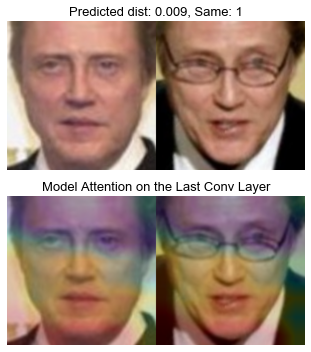

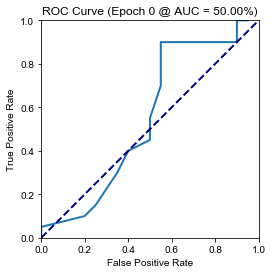

Validation - auc: 0.5000 - acc: 0.7000(+-0.02) - tpr: 0.0500(+-0.15) - dist thres: 0.0158(+-0.00)


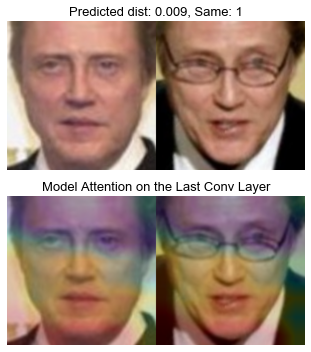

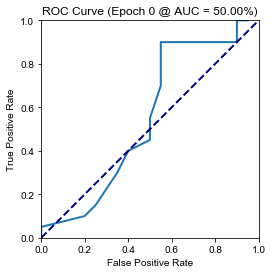

Validation - auc: 0.5000 - acc: 0.7000(+-0.02) - tpr: 0.0500(+-0.15) - dist thres: 0.0158(+-0.00)
Saving epoch 1 max auc model: 0.5000

CPU times: user 2min 52s, sys: 1min 30s, total: 4min 22s
Wall time: 5min 28s


defaultdict(list,
            {'train_att_loss': [2.176219940185547],
             'train_triplet_loss': [0.3930145502090454],
             'val_auc': [0.49999999999999994],
             'val_acc': [0.7],
             'val_masked_auc': [0.49999999999999994],
             'val_masked_acc': [0.7]})

In [58]:
%%time
train(model, train_loader, valid_loader, valid_loader, epochs=1)

>### Demo

#### Utils
`utils.py`

In [ ]:
def time_to_str(t):
    hr = int(t/60)//60
    minute = int(t/60)%60
    sec = int(t)%60   
    return f'{hr:02}h {minute:02}m {sec:02}s'

In [ ]:
class Logger(object):
    def __init__(self):
        self.terminal = sys.stdout  #在终端的输出
        self.file = None

    def open(self, file, mode='w'): #默认新建日志
        self.file = open(file, mode)

    def write(self, message, is_terminal=0, is_file=1):
        if is_terminal == 1:
            self.terminal.write(message) #在终端输出日志
            self.terminal.flush()
            #time.sleep(1)

        if is_file == 1:
            self.file.write(message) #在文件输出日志
            self.file.flush()

#### Main
由于根据不同loss，需要的数据集、模型和训练的过程都不一样，因此按情况分成三种训练方式运行，以下以softmax为例，其余请看项目代码：
`main_softmax.py`
`main_triplet.py`
`main_triplet_att.py`

In [ ]:
import sys
import argparse
import pickle
import time

In [ ]:
def run_train(config):
    # ------setup------
    out_dir = 'running_log' #保存训练日志和模型的路径
    model_name = f"{config.model}_{'att_' if config.attention else ''}{'cbam_' if config.cbam else ''}{str(EMBEDDING_DIM)}"
    out_dir = os.path.join(out_dir, model_name)
    checkpoint_dir = os.path.join(out_dir, 'checkpoint')
    if not os.path.exists(checkpoint_dir): 
        os.makedirs(checkpoint_dir) #多层创建文件夹
   
    log = Logger()
    log.open(os.path.join(out_dir, f'{model_name}_training.txt'), mode='a') #增加内容
    log.write(f'Training log @ {out_dir}\n')
    log.write(f'Device: {device}\n')
    log.write('\n')

    #------dataset------
    log.write('** Dataset setting **\n')
    (train_dataset, train_loader), (valid_dataset, valid_loader) = get_dataset(softmax_criterion=True, 
                            att_criterion=False, masked_face=config.masked_face)
    log.write(f"Dataset: VGGFace2 {'Masked' if config.masked_face else ''} Faces\n")
    log.write(f'training_samples = {train_dataset.__len__()}\n')
    log.write(f'val_samples = {valid_dataset.__len__()}\n')
    log.write(f'batch_size = {BATCH_SIZE}\n')
    log.write('\n')
    
    #------model------
    log.write('** Model setting **\n')
    model = get_model(name=config.model, embedding_dim=EMBEDDING_DIM, n_classes=N_CLASSES, att_model=config.attention, 
                        cbam=config.cbam, softmax_criterion=True, att_criterion=False, 
                        pretrained=PRETRAINED)
    log.write(f'Model: {type(model).__name__}\n')
    model.to(device) #先分配给gpu
    log.write('\n')
    
    #------train------
    log.write('** Training setting **\n')
    optimizer = get_optimizer(model, name=OPTIMIZER)
    log.write(f'criterion = arcface softmax loss\n')
    log.write(f'optimizer = {type(optimizer).__name__}\n')
    log.write(f'epochs = {config.epochs}\n')
    log.write('\n')

    #------pretrained------
    epoch_start = 0
    pretrained_path = config.pretrained_model
    if pretrained_path is not None: 
        pretrained_path = os.path.join(checkpoint_dir, pretrained_path)
        log.write(f'Loading initial_checkpoint: {pretrained_path}\n')
        model = load_model_checkpoint(model, pretrained_path, device) #加载完之后，再用DP
        # 当训练意外中断时，加载方便继续训练
        optimizer = load_optimizer_checkpoint(optimizer, pretrained_path, device)
        epoch_start = torch.load(pretrained_path, device)['epoch']
        log.write('\n')

    model = nn.DataParallel(model) #gpu多于1个时，并行运算

    #------log------
    log.write('** Start training here! **\n')
    pattern1="{: ^12}|{:-^16}|{:-^36}|\n" #开头第一行
    pattern2="{: ^6}"*2+"|"+"{: ^8}"*2+"|"+"{: ^9}"*4+"|"+"{: ^12}\n" #标题行
    pattern3="{: ^6}"+"{: ^6.4f}"+"|"+"{: ^8.4f}"*2+"|"+"{: ^9.4f}"*4+"|"+"{: ^12}\n" #内容行
    log.write(pattern1.format('',' TRAIN ',' VALID '))
    log.write(pattern2.format('epoch','lr','loss','acc','loss','acc','precision', 'recall', 'time'))
    log.write("-"*76+'\n')
    
    history = defaultdict(list)
    max_acc = 0.0
    val_loss, val_acc = 0,0 #前半周期不做validation
    start = time.time() #计时
    for e in range(epoch_start, epoch_start+config.epochs): #继续从上次的epoch训练 
        print(f'Epoch {e+1}/{epoch_start+config.epochs}')
        # 根据epoch先调整lr
        lr = adjust_learning_rate(optimizer, e)

        # 训练
        train_loss, train_acc = train_on_epoch(model, train_loader, optimizer, device)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        
        # 验证
        if valid_loader and e >= config.epochs // 2: #由于前半周期肯定不断进步，只在下半周期做validation
            val_loss, val_acc, val_precision, val_recall = val_on_epoch(model, valid_loader, device)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            history['val_precision'].append(val_precision)
            history['val_recall'].append(val_recall)

            end = time.time() #每个epoch结束后计算一次累计时间
            log.write(pattern3.format(e+1, lr, train_loss, train_acc, val_loss, val_acc, val_precision, val_recall, time_to_str(end - start)))
            
            if val_acc > max_acc:
                max_acc = val_acc #更新最大acc值
                ckpt_path = os.path.join(checkpoint_dir, f'global_max_acc_model.pth') #仅保存一个最优模型
                torch.save({
                    'epoch':e+1, 
                    'acc': val_acc,
                    'model':type(model.module).__name__,
                    'state_dict': model.module.state_dict(), #模型参数w/b信息
                    'optimizer_state_dict': optimizer.state_dict(), #包括bn的running mean和std等信息
                }, ckpt_path)
                log.write(f'Saving epoch {e+1} max acc model: {max_acc:.4f}\n')

    # 保存每个epoch的metrics结果，方便后续可视化查看训练情况
    pickle.dump(history, open(os.path.join(out_dir, f'{model_name}_history.pkl'),'wb'))

In [ ]:
def run_test(config):
    out_dir = 'running_log' #保存训练日志和模型的路径
    model_name = f"{config.model}_{'att_' if config.attention else ''}{'cbam_' if config.cbam else ''}{str(EMBEDDING_DIM)}"
    out_dir = os.path.join(out_dir, model_name)
    checkpoint_dir = os.path.join(out_dir, 'checkpoint')
    
    model = get_model(name=config.model, embedding_dim=EMBEDDING_DIM, n_classes=N_CLASSES, att_model=config.attention, 
                        cbam=config.cbam, softmax_criterion=True, att_criterion=False, 
                        pretrained=PRETRAINED)
    model.to(device) #先分配给gpu
    
    pretrained_path = config.pretrained_model
    if pretrained_path is not None: 
        pretrained_path = os.path.join(checkpoint_dir, pretrained_path)
        print(f'Loading initial_checkpoint: {pretrained_path}\n')
        model = load_model_checkpoint(model, pretrained_path, device) 
    model = nn.DataParallel(model) 
    
    image = cv2.imread(config.image_path)
    emb = predict(model, image, device) #得到真人的概率
    return emb

In [ ]:
def main(config):
    if config.mode == 'train':
        run_train(config)

    if config.mode == 'infer_test':
        config.pretrained_model = 'global_max_acc_model.pth'
        return run_test(config)

In [ ]:
if __name__ == '__main__':
    # 在终端传入参数运行模型
    parser = argparse.ArgumentParser()
    # dataset
    parser.add_argument('--masked_face', type=bool, default=True)
    parser.add_argument('--image_path', type=str, default=None, help='Image local path for testing')

    # model
    parser.add_argument('--model', type=str, default='resnet50', choices=['resnet18','resnet34','resnet50','resnet101','resnet152'])
    parser.add_argument('--attention', type=bool, default=False)
    parser.add_argument('--cbam', type=bool, default=False)

    # train
    parser.add_argument('--epochs', type=int, default=10)
    parser.add_argument('--mode', type=str, default='train', choices=['train','infer_test'])
    parser.add_argument('--pretrained_model', type=str, default=None) #预训练模型路径 global_min_acer_model.pth

    config = parser.parse_args()
    print(config)
    main(config)

> ### Evaluation
<a id='evaluation'></a>

主要围绕几种常见情形，看哪种训练组合能够得到预测率高的模型：
- 用不/戴口罩的数据，不/配合mask训练，预测不/戴口罩的照片
- 用不/带attention结构的模型，不/配合attention loss训练
- 用各自不同loss训练，或者先用[Softmax](#softmax)训练，再用Triplet loss微调

\* *AUC后的括号表示best dist threshold*
100%|

| 骨干 | Emb | CBAM | Spatial Att  | Att Loss | Softmax Loss | Triplet Loss | 戴口罩VGG | Mask图/矩形框 | AUC (戴口罩LFW) | AUC (不戴口罩LFW) |
| -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| Resnet50 |128| ✔ | ✔ |   | ✔ |  |   |      | 0.877 (1.073) | 0.974 (1.269) |
| Resnet50 |128| ✔ | ✔ |   | ✔ |  | ✔ |      | 0.955 (1.277) | 0.965 (1.261)|
| Resnet50 |128| ✔ | ✔ |   | ✔ | ✔ | ✔ |      |  |  |
| Resnet50 |128| ✔ | ✔ | ✔ | ✔ | ✔ | ✔ | Mask |  |  |

<img src='note/epoch03_LFW_Unmasked_auc_0.97.png' width=400><img src='note/epoch03_LFW_Masked_auc_0.96.png' width=400>
<img src='note/epoch05_heatmap.png' width=400>

>### Deployment  

`masked_face_recognition.py`：训练完成后，把效果最好的模型整理入文档，方便后续人脸识别调用。

In [19]:
import os
import sys
current_dir = os.path.abspath('./masked_face_recognition') #从上一级路径的总项目调用时
# current_dir = os.path.abspath('./') #从当前路径调用时
sys.path.append(os.path.join(current_dir,'model')) #增加绝对路径
sys.path.append(os.path.join(current_dir, 'preprocess'))
sys.path.append(os.path.join(current_dir, 'train'))
from summary import *
from config import *
from train.train_triplet_loss import *

In [16]:
class MaskedFaceRecognition():
    def __init__(self):
        # 加载预训练模型
        self.model = get_model(name='resnet50', embedding_dim=128, n_classes=500, att_model=True, 
                        cbam=True, softmax_criterion=False, att_criterion=False, pretrained=False)
        pretrained_path = os.path.join('running_log','resnet50_att_cbam_128', 'checkpoint', 'global_max_auc_model.pth')
        self.model = load_model_checkpoint(self.model, pretrained_path, device) 
        self.model.to(device) 
      
    def compute_face_descriptor(self, image): 
        image = cv2.resize(image, (IMAGE_SIZE,IMAGE_SIZE))
        emb = predict(self.model, image, device) 
        return emb

In [33]:
# 调用人脸识别模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
recognition = MaskedFaceRecognition()
image = cv2.imread('datasets/test.jpg')
emb = recognition.compute_face_descriptor(image)
emb.shape

(128,)